In [1]:
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def augustus_refs(df):
    out_df= pd.DataFrame()
    accessions=df["accession"].unique().tolist()
    for acc in accessions:    
        busco = pd.read_csv(f"/ebio/abt6_projects7/dliso/dlis/leon_pipeline/analysis/sqanti/ref_genes/augustus_mappings/busco_{acc}.txt", header=None)
        house = pd.read_csv(f"/ebio/abt6_projects7/dliso/dlis/leon_pipeline/analysis/sqanti/ref_genes/augustus_mappings/housekeeping_{acc}.txt", header=None)
        nlr = pd.read_csv(f"/ebio/abt6_projects7/dliso/dlis/leon_pipeline/analysis/sqanti/ref_genes/augustus_mappings/nlrs_{acc}.txt", header=None)

        busco["type"] = "busco"
        house["type"] = "housekeeping"
        nlr["type"] = "nlr"
        gene_type = pd.concat([busco,house,nlr])
        gene_type.columns = ["ref_isoform","type"]
        gene_type = gene_type.groupby("ref_isoform")["type"].apply(', '.join).reset_index()

        gene_type["ref_gene"] = gene_type["ref_isoform"].str.split(".").str[0]
        gene_type.loc[gene_type["type"] == "busco, nlr"] = "nlr"
        gene_type.loc[gene_type["type"] == "housekeeping, nlr"] = "nlr"
        gene_type.loc[gene_type["type"] == "busco, housekeeping"] = "housekeeping"

        sub=df.loc[df["accession"]==acc]
        sub = pd.merge(left=sub, right=gene_type, how='left', left_on='associated_gene', right_on='ref_gene')
        
        out_df=pd.concat([out_df,sub])
    return out_df

In [3]:
def liftoff_refs(df):
    # get_df
    accessions=df["accession"].unique().tolist()

    busco = pd.read_csv("/ebio/abt6_projects7/dliso/dlis/leon_pipeline/analysis/sqanti/ref_genes/busco_Araport11_20221221.txt", header=None)
    house = pd.read_csv("/ebio/abt6_projects7/dliso/dlis/leon_pipeline/analysis/sqanti/ref_genes/arat_housekeeping.txt", header=None)
    nlr = pd.read_csv("/ebio/abt6_projects7/dliso/dlis/leon_pipeline/analysis/sqanti/ref_genes/nlrs_in_orthogroups_20221221.txt", header=None)

    busco["type"] = "busco"
    house["type"] = "housekeeping"
    nlr["type"] = "nlr"
    gene_type = pd.concat([busco,house,nlr])
    gene_type.columns = ["ref_isoform","type"]
    gene_type = gene_type.groupby("ref_isoform")["type"].apply(', '.join).reset_index()

    gene_type["ref_gene"] = gene_type["ref_isoform"].str.split(".").str[0]
    gene_type.loc[gene_type["type"] == "busco, nlr"] = "nlr"
    gene_type.loc[gene_type["type"] == "housekeeping, nlr"] = "nlr"
    gene_type.loc[gene_type["type"] == "busco, housekeeping"] = "housekeeping"
        
    gene_ref = pd.merge(left=df, right=gene_type, how='left', left_on='associated_gene', right_on='ref_gene')
    
    return gene_ref

In [4]:
def subsample(df, len_nlr, refname):
        ### Random subsampling form the genome
        # Preparation
        n=len_nlr
        exons_all, length_all, subs_all, cats_all=[],[],[],[]
        exons_dict, length_dict, subs_dict, cats_dict={},{},{},{}
        exons_final, length_final, subs_final, cats_final={},{},{},{}
        np.random.seed(42)
        seeds = np.random.choice(range(999999), size=10000, replace=False)

        # get snapshot of one iteration
        for i in range(len(seeds)):
            sub_df = df.sample(n, random_state=seeds[i], axis=0)
            exons_all.append(sub_df["exons"])
            length_all.append(sub_df["length"])
            subs_all.append(sub_df["subcategory"])
            cats_all.append(sub_df["structural_category"])

        # count occurences of all snapshots
        for subset in exons_all:
            for gene in subset:
                if gene in exons_dict.keys():
                    exons_dict[gene] +=1
                else:
                    exons_dict[gene] = 1

        for subset in length_all:
            for gene in subset:
                if gene in length_dict.keys():
                    length_dict[gene] +=1
                else:
                    length_dict[gene] = 1

        for subset in subs_all:
            for gene in subset:
                if gene in subs_dict.keys():
                    subs_dict[gene] +=1
                else:
                    subs_dict[gene] = 1
                    
        for subset in cats_all:
            for gene in subset:
                if gene in cats_dict.keys():
                    cats_dict[gene] +=1
                else:
                    cats_dict[gene] = 1

        # average the accumulated snaphot counts by the number of snapshots and get the probability by dividing all by all genes
        for key in exons_dict.keys():
            exons_final[key] = exons_dict[key]/len(seeds)

        for key in length_dict.keys():
            length_final[key] = length_dict[key]/len(seeds)

        for key in subs_dict.keys():
            subs_final[key] = subs_dict[key]/len(seeds)
            
        for key in cats_dict.keys():
            cats_final[key] = cats_dict[key]/len(seeds)
            
        exons_iters = pd.DataFrame.from_dict(exons_final, orient='index',columns=[f"{refname}_iters_exons"])
        exons_iters[f"{refname}_iters_exons_proportion"] = exons_iters[f"{refname}_iters_exons"]/n
        
        length_iters = pd.DataFrame.from_dict(length_final, orient='index',columns=[f"{refname}_iters_length"])
        length_iters[f"{refname}_iters_length_proportion"] = length_iters[f"{refname}_iters_length"]/n
        
        subs_iters = pd.DataFrame.from_dict(subs_final, orient='index',columns=[f"{refname}_iters_subs"])
        subs_iters[f"{refname}_iters_subs_proportion"] = subs_iters[f"{refname}_iters_subs"]/n
        
        cats_iters = pd.DataFrame.from_dict(cats_final, orient='index',columns=[f"{refname}_iters_cats"])
        cats_iters[f"{refname}_iters_cats_proportion"] = cats_iters[f"{refname}_iters_cats"]/n
        
        return exons_iters, length_iters, subs_iters, cats_iters

In [32]:
names=["tama_augustus","pb_augustus","tama_liftoff","pb_liftoff"]
runs=["../01_preparation/all_runs/tama_augustus_sqanti.pkl","../01_preparation/all_runs/pb_augustus_sqanti.pkl","../01_preparation/all_runs/tama_liftoff_sqanti.pkl","../01_preparation/all_runs/pb_liftoff_sqanti.pkl"]

df_exons=pd.DataFrame()
df_length=pd.DataFrame()
df_subs=pd.DataFrame()
df_cats=pd.DataFrame()

for name, run in zip(names,runs):
    # load full df
    ref=pd.read_pickle(f"{run}")
    ref=ref.loc[ref["isoform_read_support"]>3]
    
    # add new column
    ref["cat_assign"]="None"
    # and fill new colum based on 4 categories
    ref.loc[(ref["structural_category"] != "antisense") & (ref["structural_category"] != "fusion") & (ref["structural_category"] != "intergenic"), "cat_assign"]="one2one"
    ref.loc[(ref["structural_category"] == "antisense"), "cat_assign"]="antisense"
    ref.loc[(ref["structural_category"] == "fusion"), "cat_assign"]="fusion"
    ref.loc[(ref["structural_category"] == "intergenic") | (ref["structural_category"] == "genic_intron"), "cat_assign"]="novel"
    
    # in some cases, transcripts were reported as one2one even though the reads are spanning two genes.
    # In these cases, we have "fusion reads", but splicing results in perfect cds for one gene.
    # filter them and add replace the assignment
    ref["association"] = ref["associated_gene"].str.split("_").str.len()
    ref.loc[(ref["cat_assign"]=="one2one")&(ref["association"]>1), "cat_assign"] = "fusion"
    
    ref = ref.loc[ref["cat_assign"]=="one2one"]
    
    if run == "../01_preparation/all_runs/tama_liftoff_sqanti.pkl" or run == "../01_preparation/all_runs/pb_liftoff_sqanti.pkl":
        ref =liftoff_refs(ref)
    else:
        ref =augustus_refs(ref)
        
    ref["type"].fillna('other', inplace=True)
    
    
    
    #---------------------
    
    run_exons=pd.DataFrame()
    run_length=pd.DataFrame()
    run_subs=pd.DataFrame()
    run_cats=pd.DataFrame()

    for acc in tqdm(ref["accession"].unique().tolist()):
        at = ref.loc[ref["accession"] == acc].copy()
        nlr = at.loc[at["type"] == "nlr"].copy()
        busco = at.loc[at["type"] == "busco"].copy()
        house = at.loc[at["type"] == "housekeeping"].copy()
        n=min(len(nlr), len(busco), len(house), len(at))
        refsets=[nlr, busco, house, at]
        refnames=["nlr", "busco", "house","all"]
        
        refset_exons_iters=pd.DataFrame()
        refset_length_iters=pd.DataFrame()
        refset_subs_iters=pd.DataFrame()
        refset_cats_iters=pd.DataFrame()
        for refset, refname in zip(refsets, refnames):
            exons_iters, length_iters, subs_iters, cats_iters = subsample(refset, n, refname)
            refset_exons_iters=pd.concat([refset_exons_iters,exons_iters], axis="columns")
            refset_length_iters=pd.concat([refset_length_iters,length_iters], axis="columns")
            refset_subs_iters=pd.concat([refset_subs_iters,subs_iters], axis="columns")
            refset_cats_iters=pd.concat([refset_cats_iters,cats_iters], axis="columns")

            
        ### combine all
        # Take care of exons
        a=pd.DataFrame(nlr["exons"].value_counts())
        a.columns=["nlr_exons"]
        a["nlr_exons_proportion"]=a["nlr_exons"]/len(nlr)

        b=pd.DataFrame(busco["exons"].value_counts())
        b.columns=["busco_exons"]
        b["busco_exons_proportion"]=b["busco_exons"]/len(busco)

        c=pd.DataFrame(house["exons"].value_counts())
        c.columns=["housekeeping_exons"]
        c["housekeeping_exons_proportion"]=c["housekeeping_exons"]/len(house)

        e=pd.DataFrame(at["exons"].value_counts())
        e.columns=["all_exons"]
        e["all_exons_proportion"]=e["all_exons"]/len(at)
        
        acc_exons=pd.concat([a,refset_exons_iters,b,c,e], axis="columns").fillna(0).sort_index().reset_index()
        acc_exons["accession"] = acc
        run_exons=pd.concat([run_exons, acc_exons])

        ### combine all
        # Take care of length
        a=pd.DataFrame(nlr["length"].value_counts())
        a.columns=["nlr_length"]
        a["nlr_length_proportion"]=a["nlr_length"]/len(nlr)

        b=pd.DataFrame(busco["length"].value_counts())
        b.columns=["busco_length"]
        b["busco_length_proportion"]=b["busco_length"]/len(busco)

        c=pd.DataFrame(house["length"].value_counts())
        c.columns=["housekeeping_length"]
        c["housekeeping_length_proportion"]=c["housekeeping_length"]/len(house)

        e=pd.DataFrame(at["length"].value_counts())
        e.columns=["all_length"]
        e["all_length_proportion"]=e["all_length"]/len(at)

        acc_length=pd.concat([a,refset_length_iters,b,c,e], axis="columns").fillna(0).sort_index().reset_index()
        acc_length["accession"] = acc
        run_length=pd.concat([run_length, acc_length])

        ### combine all
        # Take care of subs
        a=pd.DataFrame(nlr["subcategory"].value_counts())
        a.columns=["nlr_subs"]
        a["nlr_subs_proportion"]=a["nlr_subs"]/len(nlr)

        b=pd.DataFrame(busco["subcategory"].value_counts())
        b.columns=["busco_subs"]
        b["busco_subs_proportion"]=b["busco_subs"]/len(busco)

        c=pd.DataFrame(house["subcategory"].value_counts())
        c.columns=["housekeeping_subs"]
        c["housekeeping_subs_proportion"]=c["housekeeping_subs"]/len(house)

        e=pd.DataFrame(at["subcategory"].value_counts())
        e.columns=["all_subs"]
        e["all_subs_proportion"]=e["all_subs"]/len(at)

        acc_subs=pd.concat([a,refset_subs_iters,b,c,e], axis="columns").fillna(0).sort_index().reset_index()
        acc_subs["accession"] = acc
        run_subs=pd.concat([run_subs, acc_subs])
    
        ### combine all
        # Take care of cats
        a=pd.DataFrame(nlr["structural_category"].value_counts())
        a.columns=["nlr_cats"]
        a["nlr_cats_proportion"]=a["nlr_cats"]/len(nlr)

        b=pd.DataFrame(busco["structural_category"].value_counts())
        b.columns=["busco_cats"]
        b["busco_cats_proportion"]=b["busco_cats"]/len(busco)

        c=pd.DataFrame(house["structural_category"].value_counts())
        c.columns=["housekeeping_cats"]
        c["housekeeping_cats_proportion"]=c["housekeeping_cats"]/len(house)

        e=pd.DataFrame(at["structural_category"].value_counts())
        e.columns=["all_cats"]
        e["all_cats_proportion"]=e["all_cats"]/len(at)

        acc_cats=pd.concat([a,refset_cats_iters,b,c,e], axis="columns").fillna(0).sort_index().reset_index()
        acc_cats["accession"] = acc
        run_cats=pd.concat([run_cats, acc_cats])
    
    
    run_exons["run"] = name
    df_exons=pd.concat([df_exons, run_exons])
    
    run_length["run"] = name
    df_length=pd.concat([df_length, run_length])
    
    run_subs["run"] = name
    df_subs=pd.concat([df_subs, run_subs])
    
    run_cats["run"] = name
    df_cats=pd.concat([df_cats, run_cats])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [07:22<00:00, 24.60s/it]


In [33]:
df_exons["collapsing_tool"] = df_exons["run"].str.split("_").str[0]
df_exons["prediction_tool"] = df_exons["run"].str.split("_").str[1]
df_length["collapsing_tool"] = df_length["run"].str.split("_").str[0]
df_length["prediction_tool"] = df_length["run"].str.split("_").str[1]
df_subs["collapsing_tool"] = df_subs["run"].str.split("_").str[0]
df_subs["prediction_tool"] = df_subs["run"].str.split("_").str[1]
df_cats["collapsing_tool"] = df_cats["run"].str.split("_").str[0]
df_cats["prediction_tool"] = df_cats["run"].str.split("_").str[1]

In [34]:
df_exons.to_pickle("clear_cases_all/rs3_exons_ava.pkl")
df_length.to_pickle("clear_cases_all/rs3_length_ava.pkl")
df_subs.to_pickle("clear_cases_all/rs3_subs_ava.pkl")
df_cats.to_pickle("clear_cases_all/rs3_cats_ava.pkl")

In [116]:
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [117]:
df_subs = pd.read_pickle("clear_cases_all/rs3_subs_ava.pkl")
df_length = pd.read_pickle("clear_cases_all/rs3_length_ava.pkl")
df_exons = pd.read_pickle("clear_cases_all/rs3_exons_ava.pkl")
df_cats = pd.read_pickle("clear_cases_all/rs3_cats_ava.pkl")

In [118]:
df_subs

,index,nlr_subs,nlr_subs_proportion,nlr_iters_subs,nlr_iters_subs_proportion,busco_iters_subs,busco_iters_subs_proportion,house_iters_subs,house_iters_subs_proportion,all_iters_subs,...,busco_subs,busco_subs_proportion,housekeeping_subs,housekeeping_subs_proportion,all_subs,all_subs_proportion,accession,run,collapsing_tool,prediction_tool
0,3prime_fragment,1.0,0.008475,1.0,0.008475,1.8918,0.016032,0.0000,0.000000,2.0299,...,82.0,0.015966,0.0,0.000000,420,0.017247,at6923,tama_augustus,tama,augustus
1,5prime_fragment,5.0,0.042373,5.0,0.042373,0.9859,0.008355,1.4624,0.012393,1.0923,...,43.0,0.008372,3.0,0.012346,225,0.009239,at6923,tama_augustus,tama,augustus
2,alternative_3end,17.0,0.144068,17.0,0.144068,29.4824,0.249851,5.3740,0.045542,18.7928,...,1281.0,0.249416,11.0,0.045267,3872,0.159001,at6923,tama_augustus,tama,augustus
3,alternative_3end5end,30.0,0.254237,30.0,0.254237,52.2789,0.443042,46.5668,0.394634,52.5971,...,2279.0,0.443731,96.0,0.395062,10842,0.445220,at6923,tama_augustus,tama,augustus
4,alternative_5end,0.0,0.000000,0.0,0.000000,0.5539,0.004694,1.9429,0.016465,0.4632,...,24.0,0.004673,4.0,0.016461,96,0.003942,at6923,tama_augustus,tama,augustus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,intron_retention,0.0,0.000000,0.0,0.000000,0.0762,0.003464,0.2487,0.011305,0.1899,...,8.0,0.003548,1.0,0.011494,118,0.008708,col0,pb_liftoff,pb,liftoff
9,mono-exon,1.0,0.045455,1.0,0.045455,1.8935,0.086068,2.5070,0.113955,2.2771,...,191.0,0.084701,10.0,0.114943,1417,0.104576,col0,pb_liftoff,pb,liftoff
10,mono-exon_by_intron_retention,0.0,0.000000,0.0,0.000000,0.0000,0.000000,0.0000,0.000000,0.0334,...,0.0,0.000000,0.0,0.000000,20,0.001476,col0,pb_liftoff,pb,liftoff
11,multi-exon,0.0,0.000000,0.0,0.000000,0.1367,0.006214,0.2517,0.011441,0.1364,...,14.0,0.006208,1.0,0.011494,85,0.006273,col0,pb_liftoff,pb,liftoff


In [119]:
order=['reference_match','alternative_3end','alternative_5end','alternative_3end5end',
       '3prime_fragment','5prime_fragment','internal_fragment','multi-exon',
       'intron_retention',
       'combination_of_known_junctions','combination_of_known_splicesites','mono-exon_by_intron_retention','at_least_one_novel_splicesite',
       'mono-exon']

# Section 1: All vs All

What do I want to show here?
- What was udated by the 2 runs? Tama vs PB
- What was the impact on the individual annotations? Liftoff vs Augustus
- Is it ok to highlight only the inportant ones? Intron retention in general?
- Point towards augustus and Tama:
    - Tama has the advantage of error correction (splice sites) and the wobble walking, reducing the overall amount of updates
    - Augustus 
    - --> use hue=prediction and col=run

## 1.1) Sqanti subsections

In [120]:
sqanti_subs=df_subs[["index","accession","run","collapsing_tool","prediction_tool","nlr_subs_proportion","busco_subs_proportion","housekeeping_subs_proportion","all_iters_subs_proportion"]]

In [121]:
plot1=sqanti_subs.melt(id_vars=["index","accession","run", "collapsing_tool","prediction_tool"], value_vars=["nlr_subs_proportion","busco_subs_proportion","housekeeping_subs_proportion","all_iters_subs_proportion"])

In [122]:
plot1.head()

,index,accession,run,collapsing_tool,prediction_tool,variable,value
0,3prime_fragment,at6923,tama_augustus,tama,augustus,nlr_subs_proportion,0.008475
1,5prime_fragment,at6923,tama_augustus,tama,augustus,nlr_subs_proportion,0.042373
2,alternative_3end,at6923,tama_augustus,tama,augustus,nlr_subs_proportion,0.144068
3,alternative_3end5end,at6923,tama_augustus,tama,augustus,nlr_subs_proportion,0.254237
4,alternative_5end,at6923,tama_augustus,tama,augustus,nlr_subs_proportion,0.000000


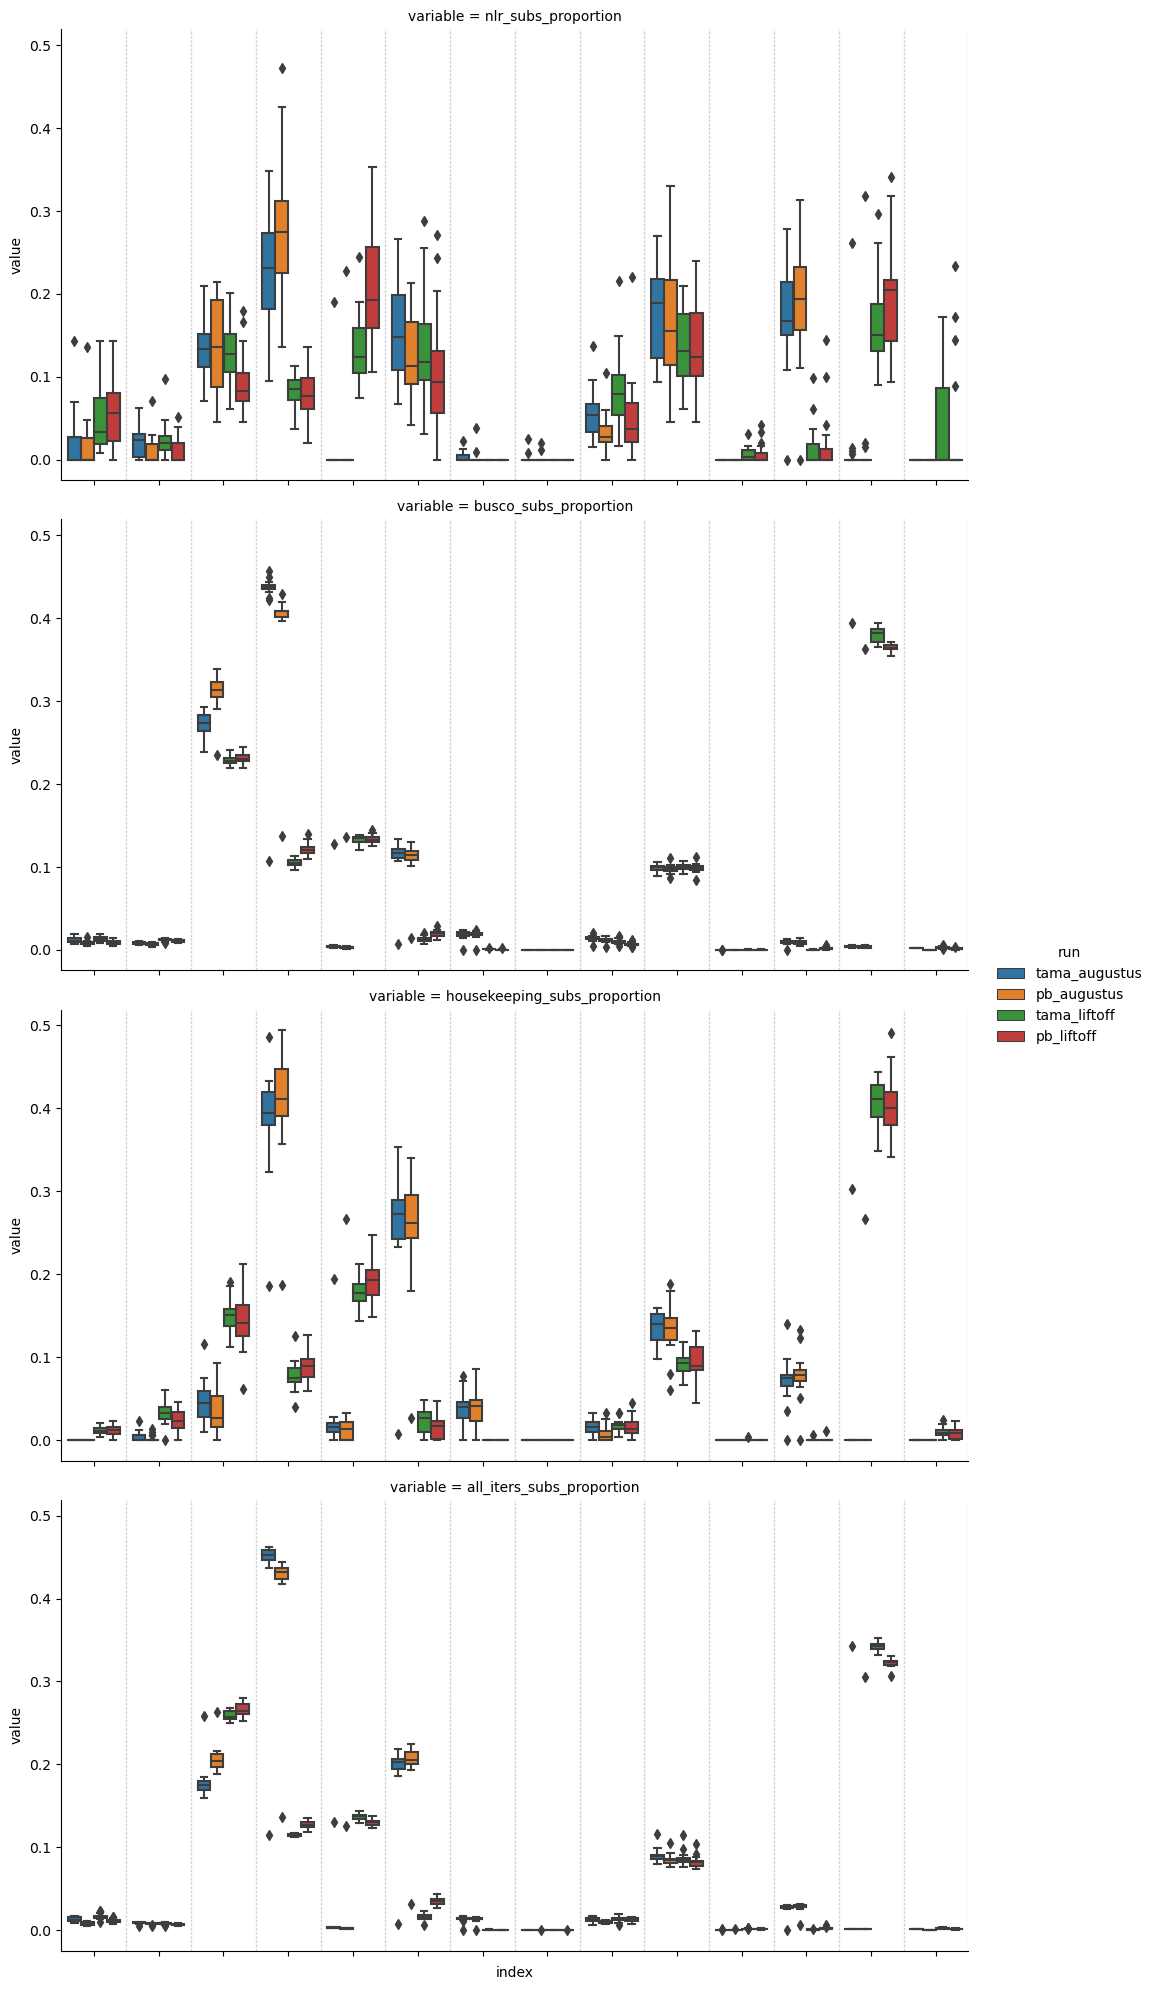

In [123]:
p1=sns.catplot(data=plot1, x="index", y="value", hue="run", col="variable", kind="box", col_wrap=1, aspect=2)
p1.set_xticklabels(rotation=45, horizontalalignment='right')

for i in range(len(plot1["index"].unique().tolist())):
    p1.map(plt.axvline, x=i+0.5, color="lightgrey", dashes=(2, 1), zorder=0,linewidth=1)

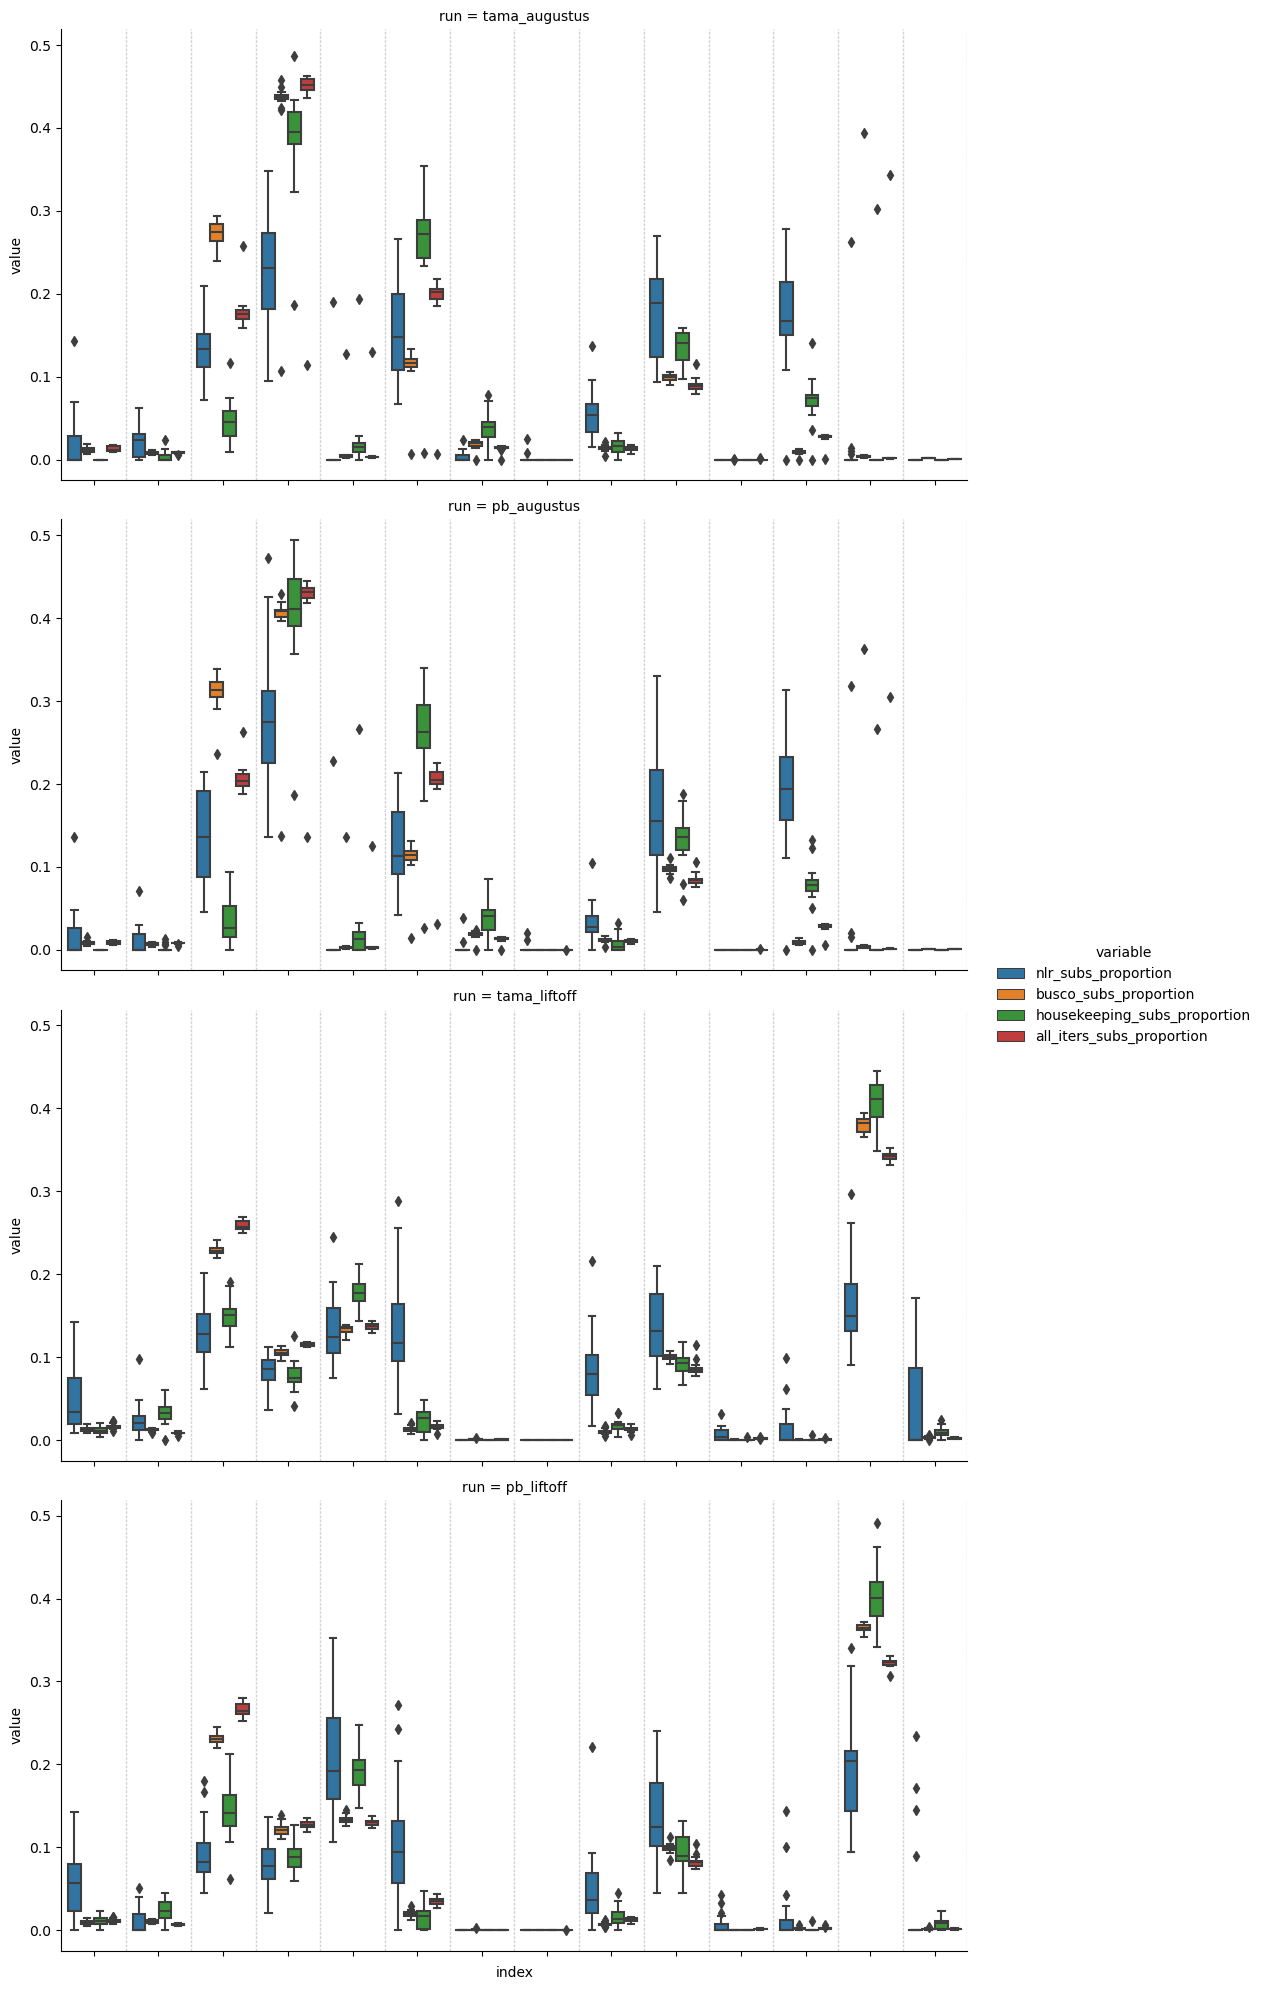

In [124]:
p1=sns.catplot(data=plot1, x="index", y="value", hue="variable", col="run", kind="box", col_wrap=1, aspect=2)
p1.set_xticklabels(rotation=45, horizontalalignment='right')

for i in range(len(plot1["index"].unique().tolist())):
    p1.map(plt.axvline, x=i+0.5, color="lightgrey", dashes=(2, 1), zorder=0,linewidth=1)

### 1.2) Sqanti collapsing tool analysis

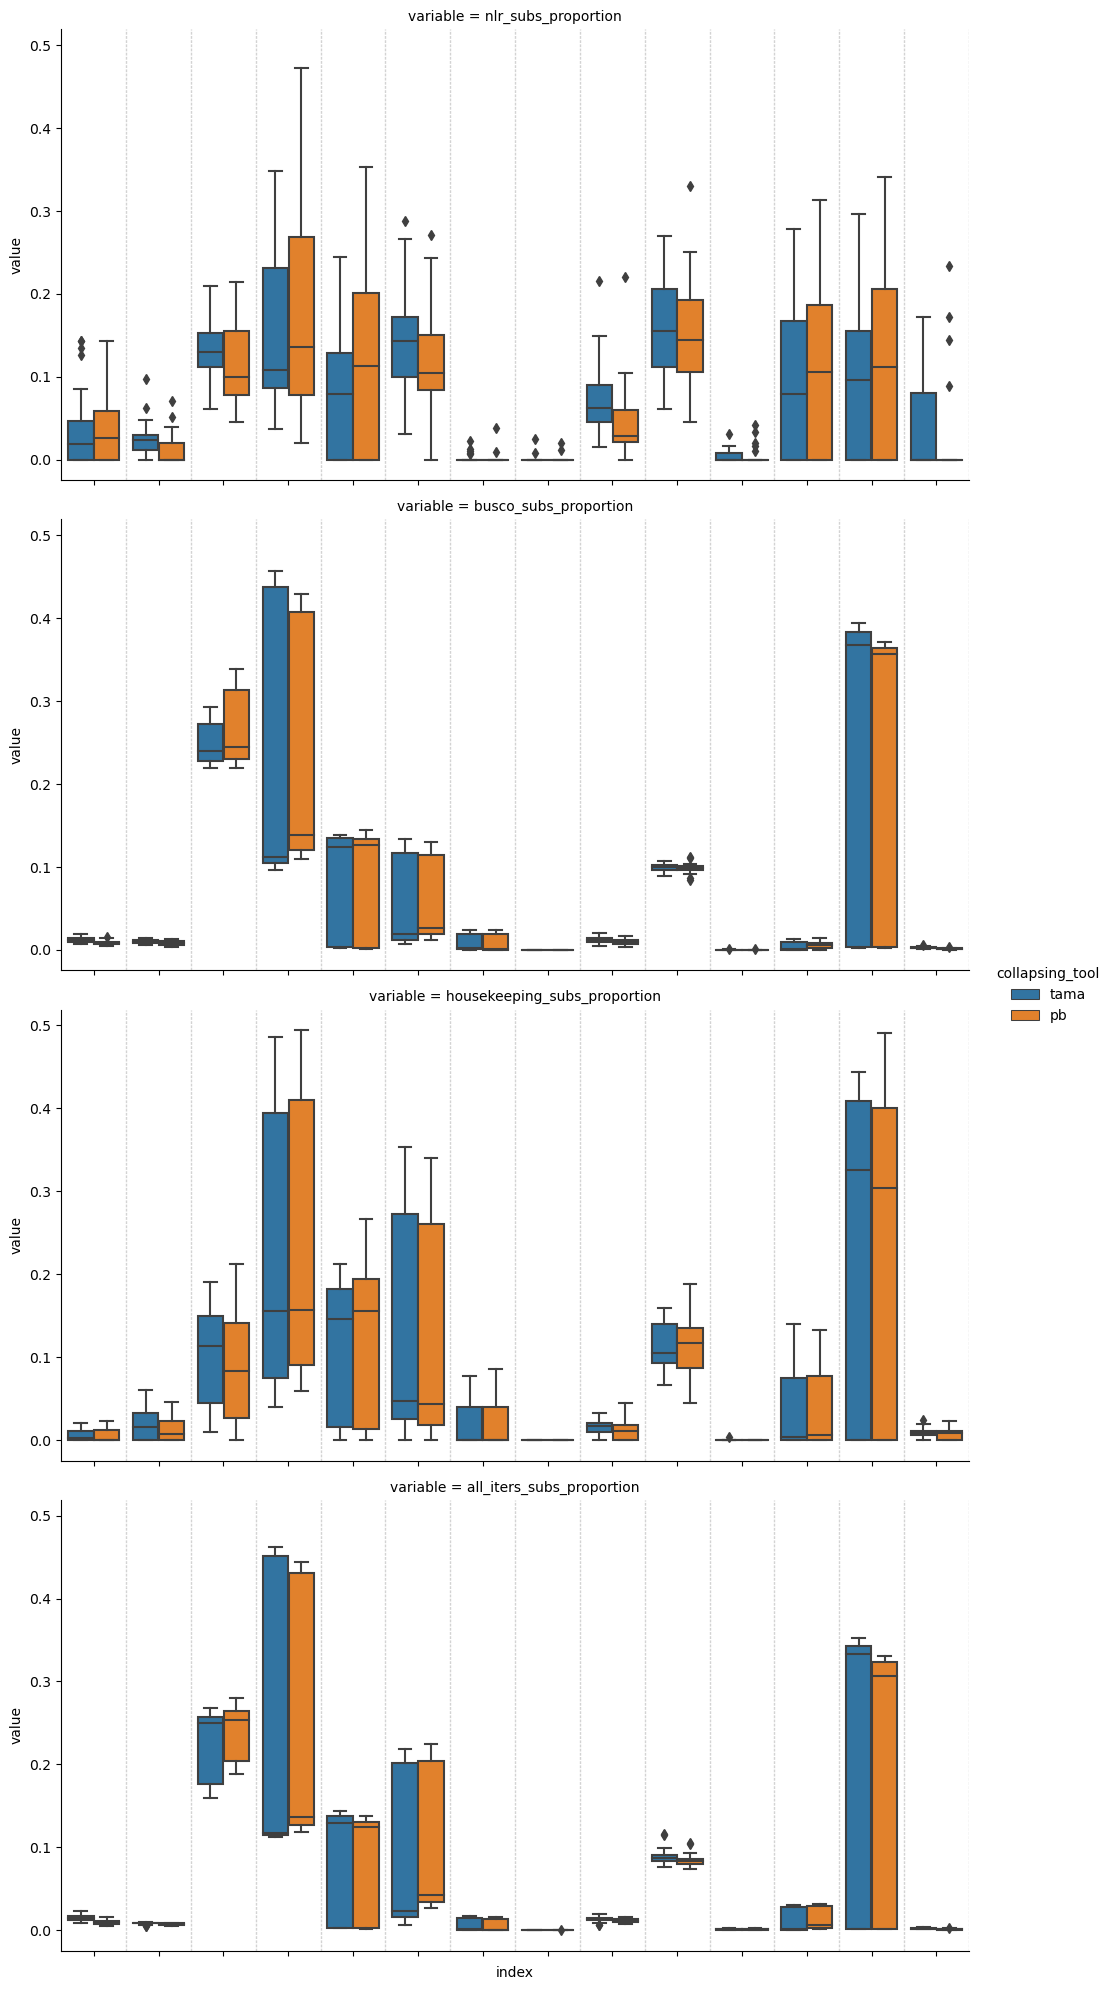

In [125]:
p1_2=sns.catplot(data=plot1, x="index", y="value", hue="collapsing_tool", col="variable", kind="box", col_wrap=1, aspect=2)
p1_2.set_xticklabels(rotation=45, horizontalalignment='right')

for i in range(len(plot1["index"].unique().tolist())):
    p1_2.map(plt.axvline, x=i+0.5, color="lightgrey", dashes=(2, 1), zorder=0,linewidth=1)

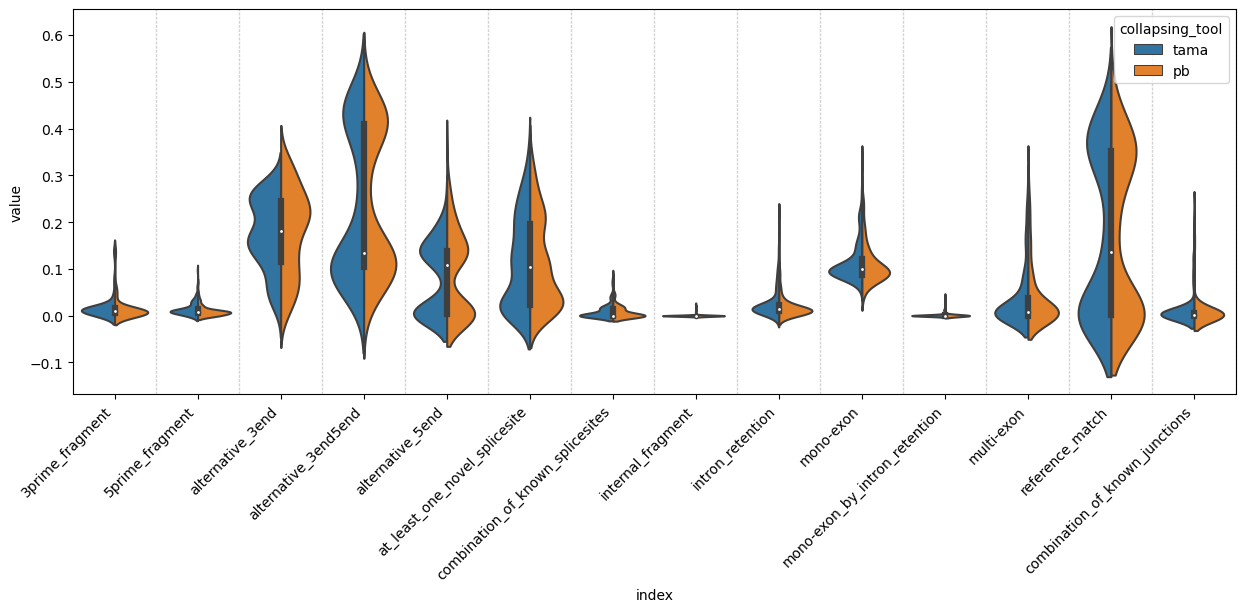

In [126]:
plt.figure(figsize=(15,5))
p1_2_2=sns.violinplot(data=plot1, x="index", y="value", hue="collapsing_tool", split=True)
#p1_2_2.set_xticks()
p1_2_2.set_xticklabels([label.get_text() for label in p1_2_2.get_xticklabels()],rotation=45, horizontalalignment='right')

for i in range(len(plot1["index"].unique().tolist())):
    plt.axvline( x=i+0.5, color="lightgrey", dashes=(2, 1), zorder=0,linewidth=1)

<Figure size 1500x500 with 0 Axes>

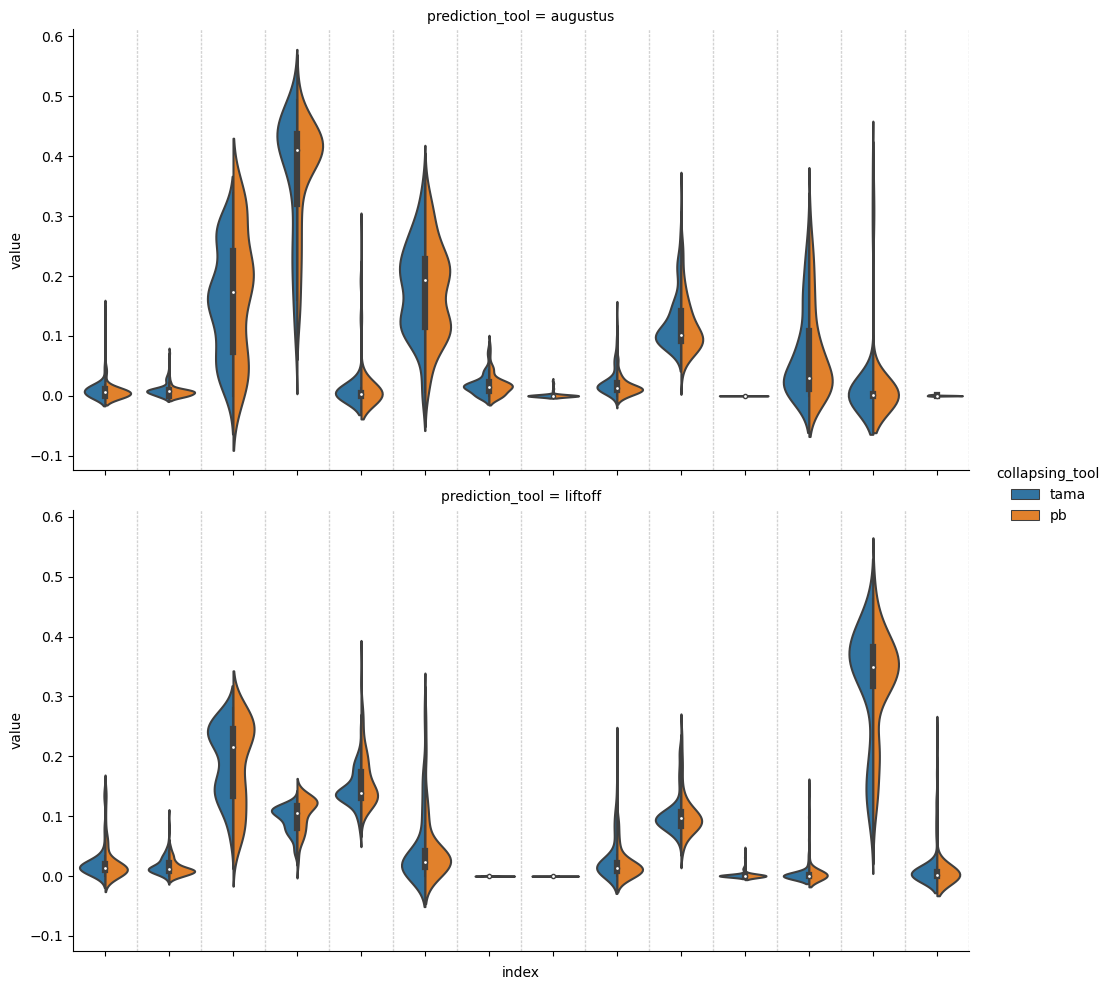

In [127]:
plt.figure(figsize=(15,5))
p1_2_3=sns.catplot(data=plot1, x="index", y="value",col="prediction_tool", hue="collapsing_tool",kind="violin", col_wrap=1, split=True, aspect=2)
#p1_2_2.set_xticks()
p1_2_3.set_xticklabels(rotation=45, horizontalalignment='right')

for i in range(len(plot1["index"].unique().tolist())):
    p1_2_3.map(plt.axvline, x=i+0.5, color="lightgrey", dashes=(2, 1), zorder=0,linewidth=1)

### 1.3) Sqanti prediction tool analysis

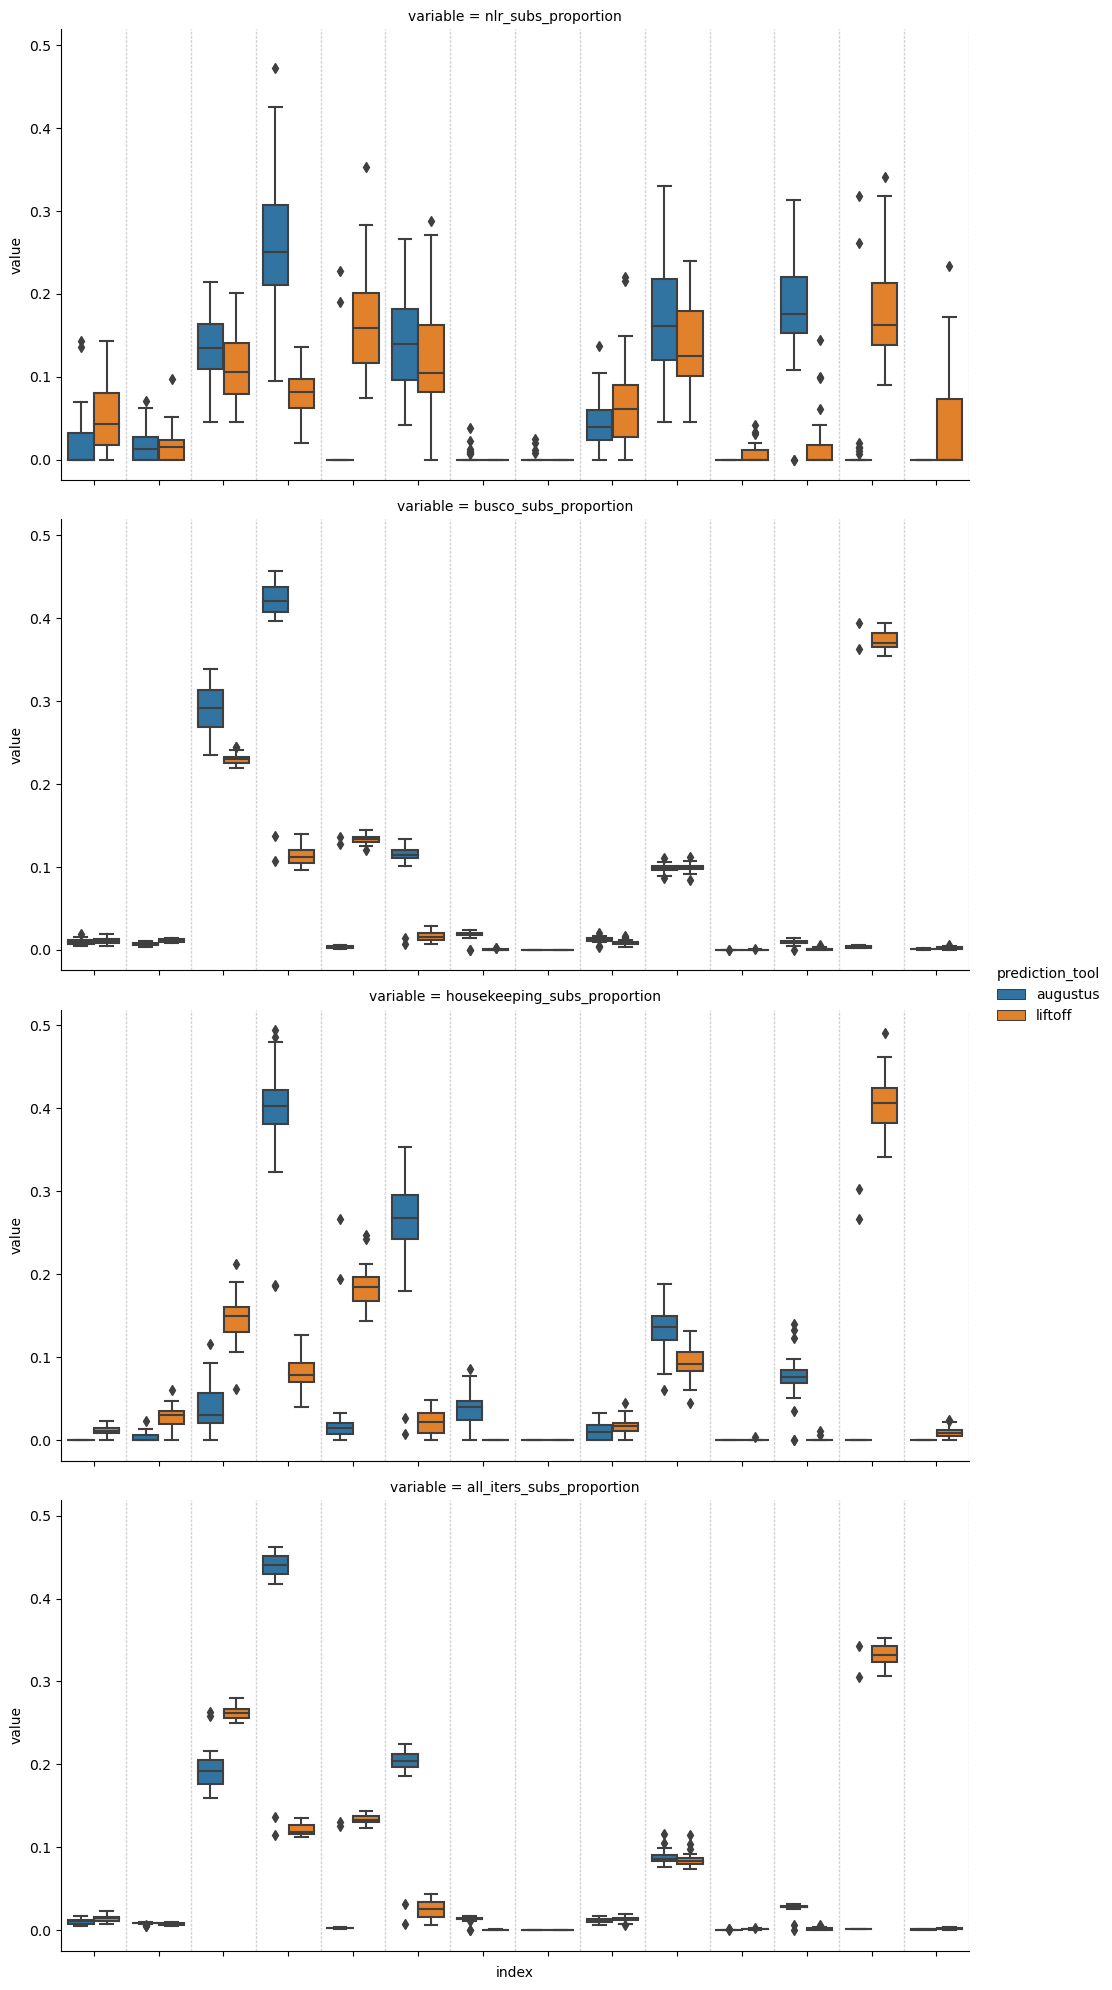

In [128]:
p1_3=sns.catplot(data=plot1, x="index", y="value", hue="prediction_tool", col="variable", kind="box", col_wrap=1, aspect=2)
p1_3.set_xticklabels(rotation=45, horizontalalignment='right')

for i in range(len(plot1["index"].unique().tolist())):
    p1_3.map(plt.axvline, x=i+0.5, color="lightgrey", dashes=(2, 1), zorder=0,linewidth=1)

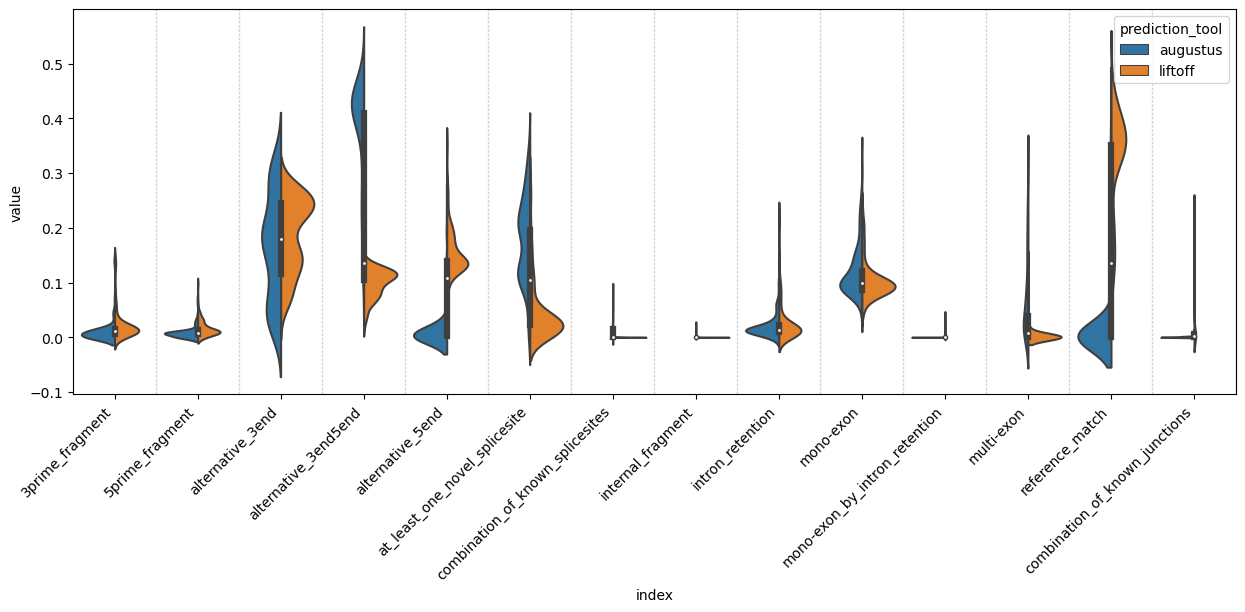

In [129]:
plt.figure(figsize=(15,5))
p1_3_2=sns.violinplot(data=plot1, x="index", y="value", hue="prediction_tool", split=True)
p1_3_2.set_xticklabels([label.get_text() for label in p1_3_2.get_xticklabels()],rotation=45, horizontalalignment='right')

for i in range(len(plot1["index"].unique().tolist())):
    plt.axvline( x=i+0.5, color="lightgrey", dashes=(2, 1), zorder=0,linewidth=1)

In [130]:
plot1["collapsing_tool"].value_counts()

tama    1864
pb      1824
Name: collapsing_tool, dtype: int64

Text(-0.35, 0.58, 'n = 18')

<Figure size 1200x500 with 0 Axes>

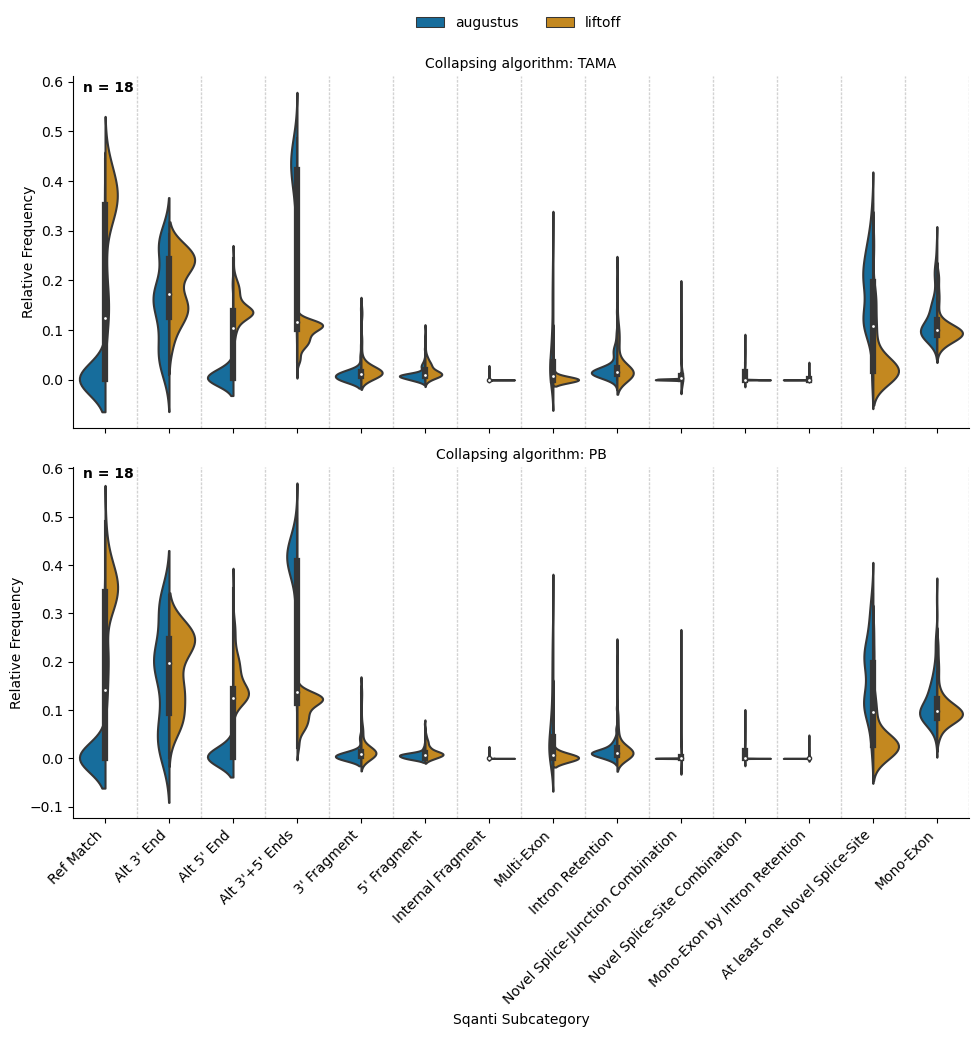

In [131]:
plt.figure(figsize=(12,5))

with sns.color_palette("colorblind"):
    p1_3_3=sns.catplot(data=plot1.replace({"tama":"TAMA","pb":"PB"}), x="index", y="value",col="collapsing_tool", hue="prediction_tool",kind="violin", col_wrap=1, split=True, aspect=2, sharey=False, order=order)

p1_3_3.set_xticklabels(["Ref Match", "Alt 3' End", "Alt 5' End","Alt 3'+5' Ends","3' Fragment", "5' Fragment", 
                        "Internal Fragment", "Multi-Exon","Intron Retention",
                        "Novel Splice-Junction Combination","Novel Splice-Site Combination","Mono-Exon by Intron Retention",
                        "At least one Novel Splice-Site","Mono-Exon"],rotation=45,horizontalalignment='right')
p1_3_3.set_xlabels("Sqanti Subcategory")
p1_3_3.set_ylabels("Relative Frequency")
p1_3_3.set_titles(col_template="Collapsing algorithm: {col_name}")
sns.move_legend(p1_3_3, "lower center",
    bbox_to_anchor=(.47, 1), ncol=3, title=None, frameon=False,
)

for i in range(len(plot1["index"].unique().tolist())):
    p1_3_3.map(plt.axvline, x=i+0.5, color="lightgrey", dashes=(2, 1), zorder=0,linewidth=1)
    
plt.text(-0.35, 1.38, "n = 18", horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.text(-0.35, 0.58, "n = 18", horizontalalignment='left', size='medium', color='black', weight='semibold')

In [132]:
fig = p1_3_3.fig
fig.savefig("rs3_clear_cases_collapsing_runs.png", bbox_inches='tight', dpi=200)

<Figure size 1500x500 with 0 Axes>

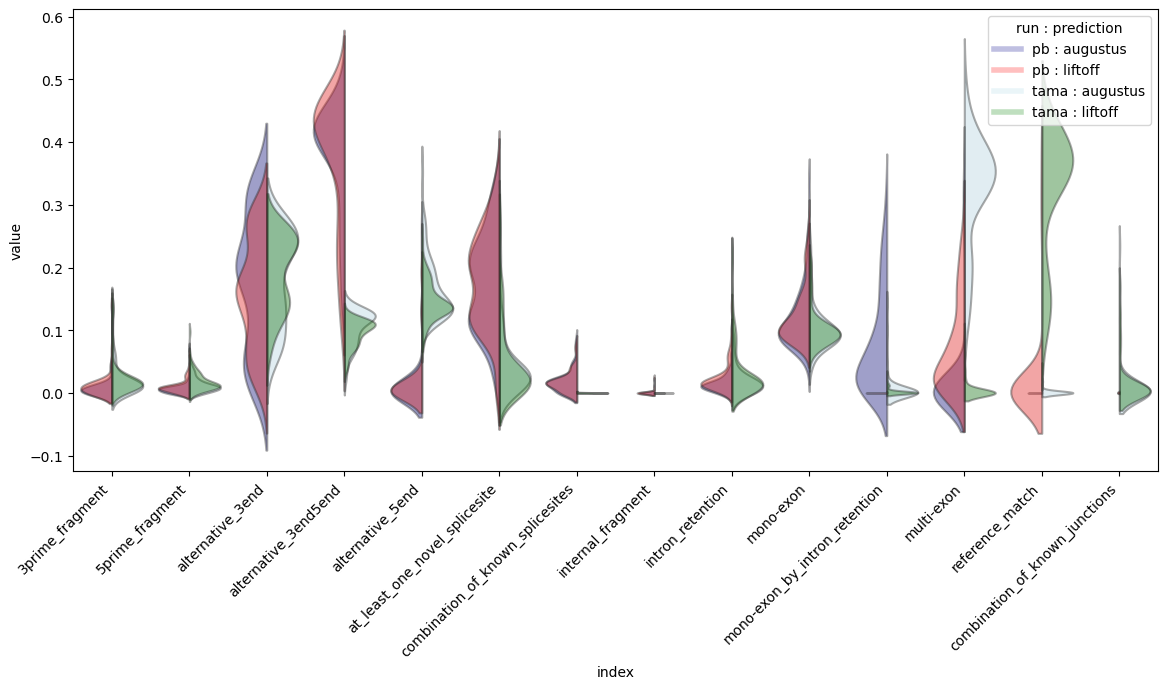

In [133]:
### https://stackoverflow.com/questions/72646635/seaborn-violin-plot-apply-hue-and-split-options-to-different-features
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.figure(figsize=(15,5))

# Configure the coloring
colors = {"pb": {"augustus": "darkblue", "liftoff": "lightblue"}, "tama": {"augustus": "red", "liftoff": "green"}}

# create figure and axes
fig, ax = plt.subplots()

# draw violins for each sex
run_types = set(plot1.collapsing_tool)
                
for run in run_types:
    sns.violinplot(
        x="index", 
        y="value", 
        hue="prediction_tool",
        data=plot1[plot1.collapsing_tool == run],
        palette=colors[run],
        split=True,
        ax=ax,
        scale="count",
        scale_hue=False,
        saturation=0.75,
        inner=None
    )

# Set transparancy for all violins
for violin in ax.collections:
    violin.set_alpha(0.40)

# Compose a custom legend
custom_lines = [
    Line2D([0], [0], color=colors[run][prediction_tool], lw=4, alpha=0.25) 
    for prediction_tool in ["augustus", "liftoff"] 
    for run in run_types
]
ax.legend(
    custom_lines, 
    [f"{run} : {prediction_tool}" for run in run_types for prediction_tool in ["augustus", "liftoff"]], 
    title="run : prediction"
)

plt.xticks(rotation=45,horizontalalignment='right')


width = 14
height = 6
fig.set_size_inches(width, height)

plt.show()

### 1.4) Col0 example

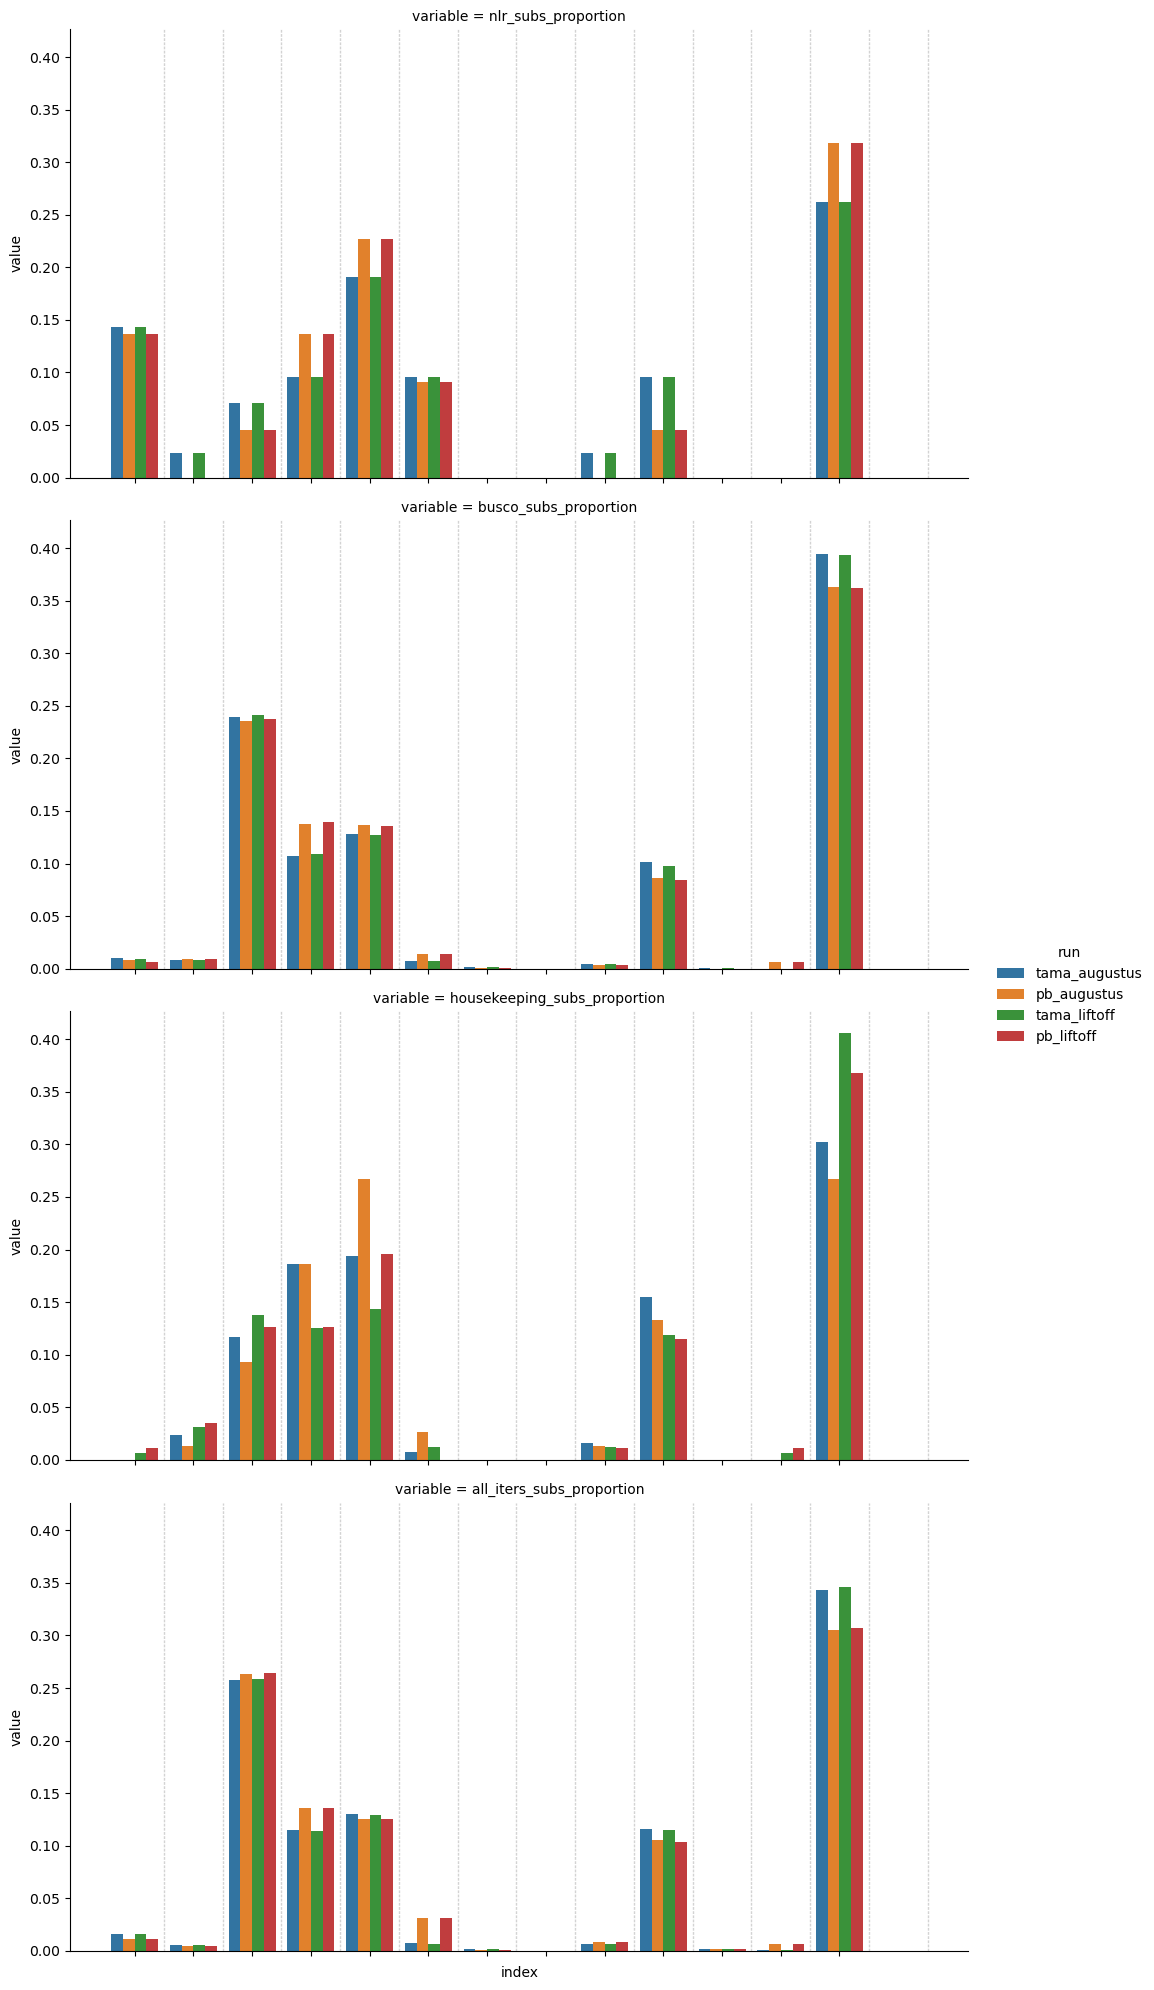

In [134]:
col0_1=plot1.loc[plot1["accession"]=="col0"]
p01=sns.catplot(data=col0_1, x="index", y="value", hue="run", col="variable", kind="bar", col_wrap=1, aspect=2)
p01.set_xticklabels(rotation=45, horizontalalignment='right')

for i in range(len(plot1["index"].unique().tolist())):
    p01.map(plt.axvline, x=i+0.5, color="lightgrey", dashes=(2, 1), zorder=0,linewidth=1)

## 2) Tama Augustus

In [135]:
ta = df_subs[(df_subs["prediction_tool"]=="augustus")&(df_subs["collapsing_tool"]=="tama")]

In [136]:
sqanti_subs=ta[["index","accession","run","nlr_subs_proportion","busco_subs_proportion","housekeeping_subs_proportion","all_iters_subs_proportion"]]

In [137]:
plot1=sqanti_subs.melt(id_vars=["index","accession","run"], value_vars=["nlr_subs_proportion","busco_subs_proportion","housekeeping_subs_proportion","all_iters_subs_proportion"])

In [138]:
ref.loc[ref["subcategory"]=="mono-exon"]["structural_category"].value_counts()

full-splice_match          22778
incomplete-splice_match      533
genic                        357
novel_in_catalog             116
Name: structural_category, dtype: int64

Text(-0.35, 0.48, 'n = 18')

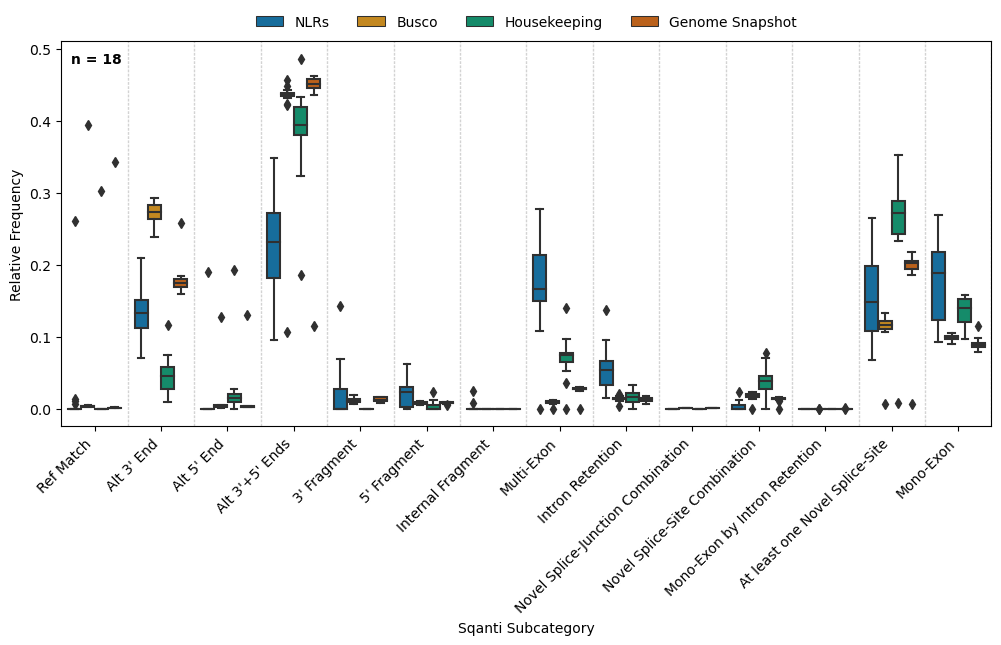

In [139]:
from matplotlib.pyplot import figure

plot1["variable_plot"] = plot1["variable"].map({'nlr_subs_proportion': 'NLRs', 'busco_subs_proportion': 'Busco', 'housekeeping_subs_proportion': 'Housekeeping', 'all_iters_subs_proportion':'Genome Snapshot'})
figure(figsize=(12, 5))

with sns.color_palette("colorblind"):
    p1_1=sns.boxplot(data=plot1, x="index", y="value", hue="variable_plot", order=order)
p1_1.set_xlabel("Sqanti Subcategory")
p1_1.set_ylabel("Relative Frequency")
p1_1.set_xticklabels(["Ref Match", "Alt 3' End", "Alt 5' End","Alt 3'+5' Ends","3' Fragment", "5' Fragment", 
                      "Internal Fragment", "Multi-Exon","Intron Retention",
                      "Novel Splice-Junction Combination","Novel Splice-Site Combination","Mono-Exon by Intron Retention",
                      "At least one Novel Splice-Site","Mono-Exon"],
                     rotation=45,
                     horizontalalignment='right')

# adding lines in general: https://community.dataquest.io/t/i-want-to-add-vertical-lines-in-a-sns-facetgrid-how-can-i-do-that/546424/2
#for i in range(len(plot1["index"].unique().tolist())):
#    p1_1.map(plt.axvline, x=i+0.5, color="lightgrey", dashes=(2, 1), zorder=0,linewidth=1)
[p1_1.axvline(x+.5,color='lightgrey', dashes=(2,1), linewidth=1) for x in p1_1.get_xticks()]


## https://stackoverflow.com/questions/60350781/edit-legend-title-and-labels-of-seaborn-scatterplot-and-countplot

#p1_1.legend(legend_handles, ['NLRs', 'Busco','Housekeeling','Full Genome'], title='Gene Sets', bbox_to_anchor=(1.05, 1))


#p1_1.legend(title='Gene Sets', bbox_to_anchor=(1.05, 1))
sns.move_legend(
    p1_1, "lower center",
    bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False,
)
plt.text(-0.35, 0.48, "n = 18", horizontalalignment='left', size='medium', color='black', weight='semibold')

In [140]:
fig = p1_1.get_figure()
fig.savefig("rs3_clear_cases_tama_augustus_subcategories.png", bbox_inches='tight', dpi=200)

### Intron retention + Genic

In [362]:
def subsample_ret_mono(df, len_nlr, refname):
        ### Random subsampling form the genome
        # Preparation
        n=len_nlr
        cats_all=[]
        cats_dict={}
        cats_final={}
        np.random.seed(42)
        seeds = np.random.choice(range(999999), size=10000, replace=False)

        # get snapshot of one iteration
        for i in range(len(seeds)):
            sub_df = df.sample(n, random_state=seeds[i], axis=0)
            cats_all.append(sub_df["structural_category"])

        # count occurences of all snapshots                  
        for subset in cats_all:
            for gene in subset:
                if gene in cats_dict.keys():
                    cats_dict[gene] +=1
                else:
                    cats_dict[gene] = 1

        # average the accumulated snaphot counts by the number of snapshots and get the probability by dividing all by all genes          
        for key in cats_dict.keys():
            cats_final[key] = cats_dict[key]/len(seeds)
            
        
        cats_iters = pd.DataFrame.from_dict(cats_final, orient='index',columns=[f"{refname}_iters_cats"])
        cats_iters[f"{refname}_iters_cats_proportion"] = cats_iters[f"{refname}_iters_cats"]/n
        
        return cats_iters

In [363]:
ref=pd.read_pickle("../01_preparation/all_runs/tama_augustus_sqanti.pkl")

ref["cat_assign"]="None"
# and fill new colum based on 4 categories
ref.loc[(ref["structural_category"] != "antisense") & (ref["structural_category"] != "fusion") & (ref["structural_category"] != "intergenic"), "cat_assign"]="one2one"
ref.loc[(ref["structural_category"] == "antisense"), "cat_assign"]="antisense"
ref.loc[(ref["structural_category"] == "fusion"), "cat_assign"]="fusion"
ref.loc[(ref["structural_category"] == "intergenic") | (ref["structural_category"] == "genic_intron"), "cat_assign"]="novel"

# in some cases, transcripts were reported as one2one even though the reads are spanning two genes.
# In these cases, we have "fusion reads", but splicing results in perfect cds for one gene.
# filter them and add replace the assignment
ref["association"] = ref["associated_gene"].str.split("_").str.len()
ref.loc[(ref["cat_assign"]=="one2one")&(ref["association"]>1), "cat_assign"] = "fusion"

In [364]:
ref=ref.loc[ref["cat_assign"]=="one2one"]

ref_ret=ref.loc[ref["subcategory"]=="intron_retention"]
ref_ret=augustus_refs(ref_ret)
ref_ret["type"].fillna('other', inplace=True)


ref_mono=ref.loc[ref["subcategory"]=="mono-exon"]
ref_mono=augustus_refs(ref_mono)
ref_mono["type"].fillna('other', inplace=True)

In [365]:
# Intron retention

In [366]:
run_cats_ret=pd.DataFrame()

for acc in tqdm(ref_ret["accession"].unique().tolist()):
    at = ref_ret.loc[ref_ret["accession"] == acc].copy()
    nlr = at.loc[at["type"] == "nlr"].copy()
    busco = at.loc[at["type"] == "busco"].copy()
    house = at.loc[at["type"] == "housekeeping"].copy()
    n=min(len(nlr), len(busco), len(house), len(at))
    refsets=[nlr, busco, house, at]
    refnames=["nlr", "busco", "house","all"]

    refset_cats_iters=pd.DataFrame()
    for refset, refname in zip(refsets, refnames):

        cats_iters = subsample_ret_mono(refset, n, refname)

        refset_cats_iters=pd.concat([refset_cats_iters,cats_iters], axis="columns")

    ### combine all
    # Take care of cats
    a=pd.DataFrame(nlr["structural_category"].value_counts())
    a.columns=["nlr_cats"]
    a["nlr_cats_proportion"]=a["nlr_cats"]/len(nlr)

    b=pd.DataFrame(busco["structural_category"].value_counts())
    b.columns=["busco_cats"]
    b["busco_cats_proportion"]=b["busco_cats"]/len(busco)

    c=pd.DataFrame(house["structural_category"].value_counts())
    c.columns=["housekeeping_cats"]
    c["housekeeping_cats_proportion"]=c["housekeeping_cats"]/len(house)

    e=pd.DataFrame(at["structural_category"].value_counts())
    e.columns=["all_cats"]
    e["all_cats_proportion"]=e["all_cats"]/len(at)

    acc_cats=pd.concat([a,refset_cats_iters,b,c,e], axis="columns").fillna(0).sort_index().reset_index()
    acc_cats["accession"] = acc
    run_cats_ret=pd.concat([run_cats_ret, acc_cats])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [05:33<00:00, 18.54s/it]


In [367]:
run_cats_ret.columns

Index(['index', 'nlr_cats', 'nlr_cats_proportion', 'nlr_iters_cats',
       'nlr_iters_cats_proportion', 'busco_iters_cats',
       'busco_iters_cats_proportion', 'house_iters_cats',
       'house_iters_cats_proportion', 'all_iters_cats',
       'all_iters_cats_proportion', 'busco_cats', 'busco_cats_proportion',
       'housekeeping_cats', 'housekeeping_cats_proportion', 'all_cats',
       'all_cats_proportion', 'accession'],
      dtype='object')

In [368]:
ret_cats=run_cats_ret[["index","accession","nlr_cats_proportion","busco_cats_proportion","housekeeping_cats_proportion","all_iters_cats_proportion"]]
plot2_2=ret_cats.melt(id_vars=["index","accession"], value_vars=["nlr_cats_proportion","busco_cats_proportion","housekeeping_cats_proportion","all_iters_cats_proportion"])

plot2_2["variable_plot"] = plot2_2["variable"].map({'nlr_cats_proportion': 'NLRs', 'busco_cats_proportion': 'Busco', 'housekeeping_cats_proportion': 'Housekeeping', 'all_iters_cats_proportion':'Genome Snapshot'})

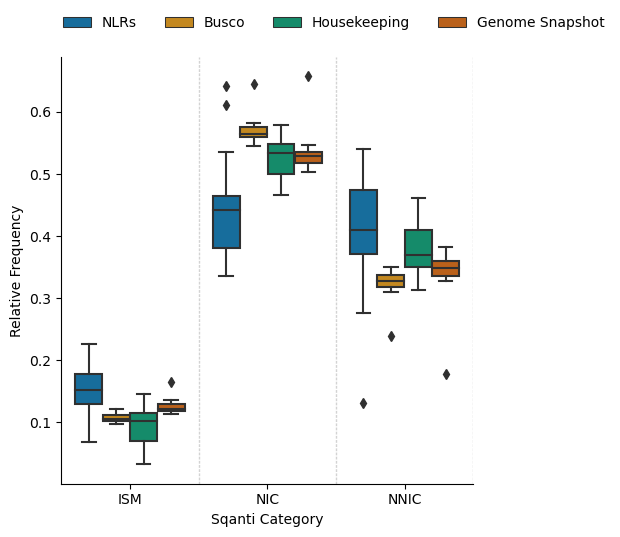

In [369]:
sns.set_palette(sns.color_palette("colorblind"))
p2_2=sns.catplot(data=plot2_2, x="index", y="value", hue="variable_plot", kind="box")
#p2_2.set_xticklabels(rotation=45, horizontalalignment='right')
p2_2.set_xticklabels(["ISM","NIC","NNIC"])
p2_2.set_ylabels("Relative Frequency")
p2_2.set_xlabels("Sqanti Category")

# adding lines in general: https://community.dataquest.io/t/i-want-to-add-vertical-lines-in-a-sns-facetgrid-how-can-i-do-that/546424/2
for i in range(len(plot2_2["index"].unique().tolist())):
    p2_2.map(plt.axvline, x=i+0.5, color="lightgrey", dashes=(2, 1), zorder=0,linewidth=1)
    
sns.move_legend(
    p2_2, "lower center",
    bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False,
)

In [370]:
fig = p2_2.fig
fig.savefig("clear_cases_tama_augustus_intronret_cat.png", bbox_inches='tight')

Text(-0.4, 0.63, 'n = 18')

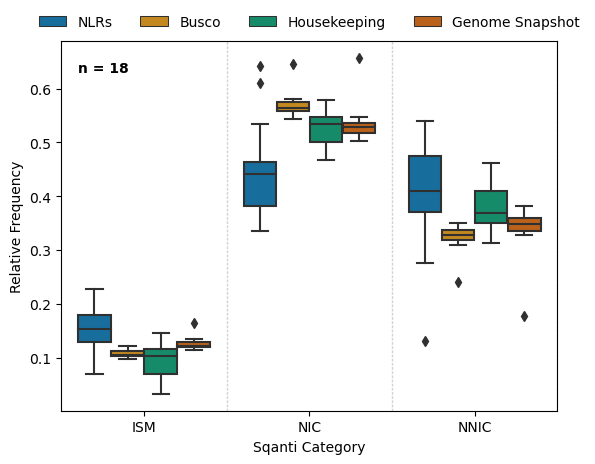

In [374]:
#boxplot
sns.set_palette(sns.color_palette("colorblind"))

p2_2=sns.boxplot(data=plot2_2, x="index", y="value", hue="variable_plot")
p2_2.set_xticklabels(["ISM","NIC","NNIC"])
p2_2.set_ylabel("Relative Frequency")
p2_2.set_xlabel("Sqanti Category")

# adding lines in general: https://community.dataquest.io/t/i-want-to-add-vertical-lines-in-a-sns-facetgrid-how-can-i-do-that/546424/2
#for i in range(len(plot2_3["index"].unique().tolist())):
#    p2_3.map(plt.axvline, x=i+0.5, color="lightgrey", dashes=(2, 1), zorder=0,linewidth=1)

[p2_2.axvline(x+.5,color='lightgrey', dashes=(2,1), linewidth=1) for x in p2_2.get_xticks()]

sns.move_legend(
    p2_2, "lower center",
    bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False,
)
plt.text(-0.4, 0.63, "n = 18", horizontalalignment='left', size='medium', color='black', weight='semibold')


In [296]:
fig = p2_2.get_figure()
fig.savefig("clear_cases_tama_augustus_intronret_cat_box.png", bbox_inches='tight')

In [176]:
run_cats_ret.to_pickle("clear_cases_all/cats_ret.pkl")

In [168]:
# mono exon

In [169]:
run_cats_mono=pd.DataFrame()

for acc in tqdm(ref_mono["accession"].unique().tolist()):
    at = ref_mono.loc[ref_mono["accession"] == acc].copy()
    nlr = at.loc[at["type"] == "nlr"].copy()
    busco = at.loc[at["type"] == "busco"].copy()
    house = at.loc[at["type"] == "housekeeping"].copy()
    n=min(len(nlr), len(busco), len(house), len(at))
    refsets=[nlr, busco, house, at]
    refnames=["nlr", "busco", "house","all"]

    refset_cats_iters=pd.DataFrame()
    for refset, refname in zip(refsets, refnames):

        cats_iters = subsample_ret_mono(refset, n, refname)

        refset_cats_iters=pd.concat([refset_cats_iters,cats_iters], axis="columns")

    ### combine all
    # Take care of cats
    a=pd.DataFrame(nlr["structural_category"].value_counts())
    a.columns=["nlr_cats"]
    a["nlr_cats_proportion"]=a["nlr_cats"]/len(nlr)

    b=pd.DataFrame(busco["structural_category"].value_counts())
    b.columns=["busco_cats"]
    b["busco_cats_proportion"]=b["busco_cats"]/len(busco)

    c=pd.DataFrame(house["structural_category"].value_counts())
    c.columns=["housekeeping_cats"]
    c["housekeeping_cats_proportion"]=c["housekeeping_cats"]/len(house)

    e=pd.DataFrame(at["structural_category"].value_counts())
    e.columns=["all_cats"]
    e["all_cats_proportion"]=e["all_cats"]/len(at)

    acc_cats=pd.concat([a,refset_cats_iters,b,c,e], axis="columns").fillna(0).sort_index().reset_index()
    acc_cats["accession"] = acc
    run_cats_mono=pd.concat([run_cats_mono, acc_cats])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [06:44<00:00, 22.49s/it]


In [170]:
run_cats_mono.columns

Index(['index', 'nlr_cats', 'nlr_cats_proportion', 'nlr_iters_cats',
       'nlr_iters_cats_proportion', 'busco_iters_cats',
       'busco_iters_cats_proportion', 'house_iters_cats',
       'house_iters_cats_proportion', 'all_iters_cats',
       'all_iters_cats_proportion', 'busco_cats', 'busco_cats_proportion',
       'housekeeping_cats', 'housekeeping_cats_proportion', 'all_cats',
       'all_cats_proportion', 'accession'],
      dtype='object')

In [273]:
mono_cats=run_cats_mono[["index","accession","nlr_cats_proportion","busco_cats_proportion","housekeeping_cats_proportion","all_iters_cats_proportion"]]
plot2_3=mono_cats.melt(id_vars=["index","accession"], value_vars=["nlr_cats_proportion","busco_cats_proportion","housekeeping_cats_proportion","all_iters_cats_proportion"])

plot2_3["variable_plot"] = plot2_3["variable"].map({'nlr_cats_proportion': 'NLRs', 'busco_cats_proportion': 'Busco', 'housekeeping_cats_proportion': 'Housekeeping', 'all_iters_cats_proportion':'Genome Snapshot'})

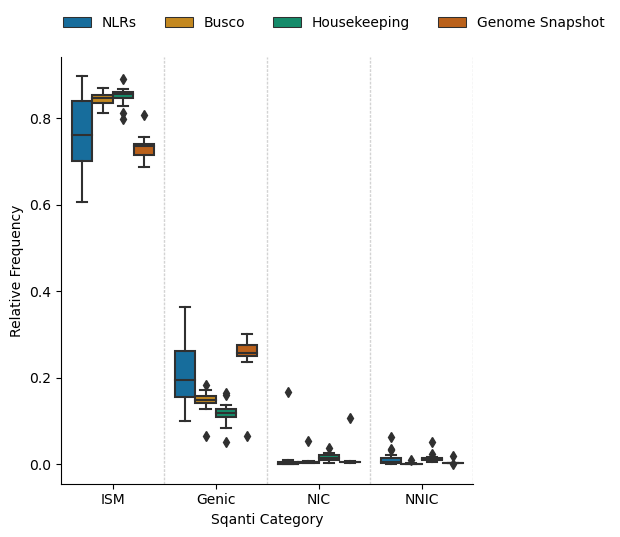

In [289]:
#catplot
sns.set_palette(sns.color_palette("colorblind"))

p2_3=sns.catplot(data=plot2_3, x="index", y="value", hue="variable_plot", kind="box")
#p2_3.set_xticklabels(rotation=45, horizontalalignment='right')
p2_3.set_xticklabels(["ISM","Genic","NIC","NNIC"])
p2_3.set_ylabels("Relative Frequency")
p2_3.set_xlabels("Sqanti Category")

# adding lines in general: https://community.dataquest.io/t/i-want-to-add-vertical-lines-in-a-sns-facetgrid-how-can-i-do-that/546424/2
for i in range(len(plot2_3["index"].unique().tolist())):
    p2_3.map(plt.axvline, x=i+0.5, color="lightgrey", dashes=(2, 1), zorder=0,linewidth=1)
    
sns.move_legend(
    p2_3, "lower center",
    bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False,
)

In [276]:
fig = p2_3.fig
fig.savefig("clear_cases_tama_augustus_mono_cat.png", bbox_inches='tight')

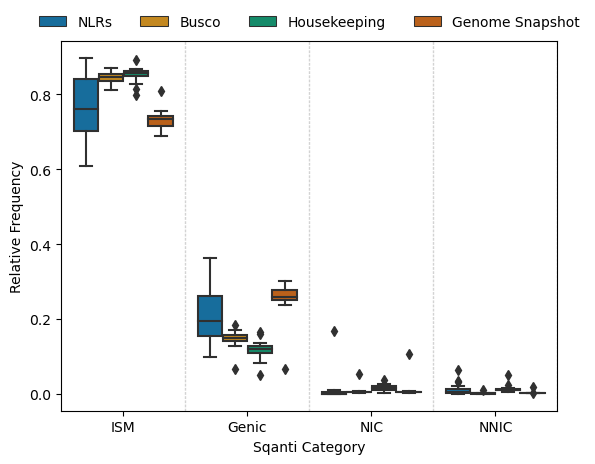

In [291]:
#boxplot
sns.set_palette(sns.color_palette("colorblind"))

p2_3=sns.boxplot(data=plot2_3, x="index", y="value", hue="variable_plot")
p2_3.set_xticklabels(["ISM","Genic","NIC","NNIC"])
p2_3.set_ylabel("Relative Frequency")
p2_3.set_xlabel("Sqanti Category")

# adding lines in general: https://community.dataquest.io/t/i-want-to-add-vertical-lines-in-a-sns-facetgrid-how-can-i-do-that/546424/2
#for i in range(len(plot2_3["index"].unique().tolist())):
#    p2_3.map(plt.axvline, x=i+0.5, color="lightgrey", dashes=(2, 1), zorder=0,linewidth=1)

[p2_3.axvline(x+.5,color='lightgrey', dashes=(2,1), linewidth=1) for x in p2_3.get_xticks()]

sns.move_legend(
    p2_3, "lower center",
    bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False,
)


In [293]:
fig = p2_3.get_figure()
fig.savefig("clear_cases_tama_augustus_mono_cat_box.png", bbox_inches='tight')

In [177]:
run_cats_mono.to_pickle("clear_cases_all/cats_mono.pkl")

In [173]:
# categories general

In [297]:
#ref=pd.read_pickle("clear_cases_all/cats_ava.pkl")
ref=pd.read_pickle("../../analysis/2_clear_cases/clear_cases_all/cats_ava.pkl")

In [298]:
ref_cats=ref[["index","accession","nlr_cats_proportion","busco_cats_proportion","housekeeping_cats_proportion","all_iters_cats_proportion"]]
plot2_4=ref_cats.melt(id_vars=["index","accession"], value_vars=["nlr_cats_proportion","busco_cats_proportion","housekeeping_cats_proportion","all_iters_cats_proportion"])

plot2_4["variable_plot"] = plot2_4["variable"].map({'nlr_cats_proportion': 'NLRs', 'busco_cats_proportion': 'Busco', 'housekeeping_cats_proportion': 'Housekeeping', 'all_iters_cats_proportion':'Genome Snapshot'})

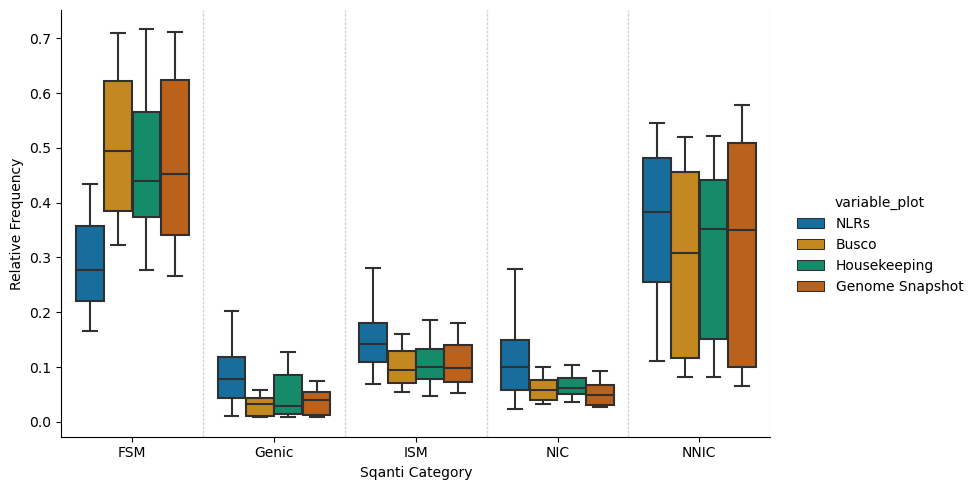

In [299]:
p2_4=sns.catplot(data=plot2_4, x="index", y="value", hue="variable_plot", kind="box", aspect=1.6)

p2_4.set_xticklabels(["FSM","Genic","ISM","NIC","NNIC"])
p2_4.set_ylabels("Relative Frequency")
p2_4.set_xlabels("Sqanti Category")

# adding lines in general: https://community.dataquest.io/t/i-want-to-add-vertical-lines-in-a-sns-facetgrid-how-can-i-do-that/546424/2
for i in range(len(plot2_4["index"].unique().tolist())):
    p2_4.map(plt.axvline, x=i+0.5, color="lightgrey", dashes=(2, 1), zorder=0,linewidth=1)
    
sns.move_legend(
    p2_3, "lower center",
    bbox_to_anchor=(.5, 1), ncol=2, title=None, frameon=False,
)

## NLR

In [305]:
ref = pd.read_pickle("../01_preparation/clear-fusion/clear-fusion_tama_augustus.pkl")
ref = ref.loc[(ref["cat_assign"] == "one2one")&(ref["type"]=="nlr")]

In [306]:
for i in ref.columns:
    if ref[i].isnull().values.any():
        print(i)

Sqanti_ORF_seq
isoforms_per_ORFs


In [307]:
ref.loc[ref["Sqanti_ORF_seq"].isna()]

,gene,isoform,accession,associated_gene,associated_transcript,exons,length,isoform_read_support,gene_read_support,structural_category,subcategory,Sqanti_ORF_seq,cat_assign,association,cat_read_support,gene_association_read_support,type,isoforms_per_gene,ORFs_per_gene,isoforms_per_ORFs
495,G3279,G3279.31,at6923,g6081,g6081.t1,1,202,1,170,full-splice_match,mono-exon,NaN,one2one,1,170,170,nlr,32,6,NaN
1088,G10891,G10891.10,at6923,g21935,novel,3,1078,1,10,novel_in_catalog,intron_retention,NaN,one2one,1,10,10,nlr,10,10,NaN
1423,G11402,G11402.1,at6923,g22779,novel,1,1870,1,9,genic,mono-exon,NaN,one2one,1,9,3,nlr,8,6,NaN
1513,G11495,G11495.2,at6923,g22929,novel,1,1571,1,5,genic,mono-exon,NaN,one2one,1,5,5,nlr,5,5,NaN
1981,G15255,G15255.22,at6923,g29793,novel,1,297,1,25,genic,mono-exon,NaN,one2one,1,25,25,nlr,22,9,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32684,G9088,G9088.48,col0,AT3G50950,novel,1,1722,1,84,genic,mono-exon,NaN,one2one,1,84,84,nlr,48,10,NaN
32745,G10806,G10806.13,col0,AT4G16890,novel,1,260,1,37,genic,mono-exon,NaN,one2one,1,37,37,nlr,36,22,NaN
33272,G11042,G11042.1,col0,AT4G20480,novel,2,1315,1,5,novel_in_catalog,intron_retention,NaN,one2one,1,5,5,nlr,5,4,NaN
33518,G14805,G14805.4,col0,AT5G46470,novel,4,1008,1,4,novel_not_in_catalog,at_least_one_novel_splicesite,NaN,one2one,1,4,4,nlr,4,4,NaN


[Text(0, 0, 'Ref Match'),
 Text(1, 0, "Alt 3' End"),
 Text(2, 0, "Alt 5' End"),
 Text(3, 0, "Alt 3'+5' Ends"),
 Text(4, 0, "3' Fragment"),
 Text(5, 0, "5' Fragment"),
 Text(6, 0, 'Internal Fragment'),
 Text(7, 0, 'Multi-Exon'),
 Text(8, 0, 'Intron Retention'),
 Text(9, 0, 'Novel Splice-Site Cobination'),
 Text(10, 0, 'Novel Splice-Junction Combination'),
 Text(11, 0, 'Mono-Exon by Intron Retention'),
 Text(12, 0, 'At least one Novel Splice-Site'),
 Text(13, 0, 'Mono-Exon')]

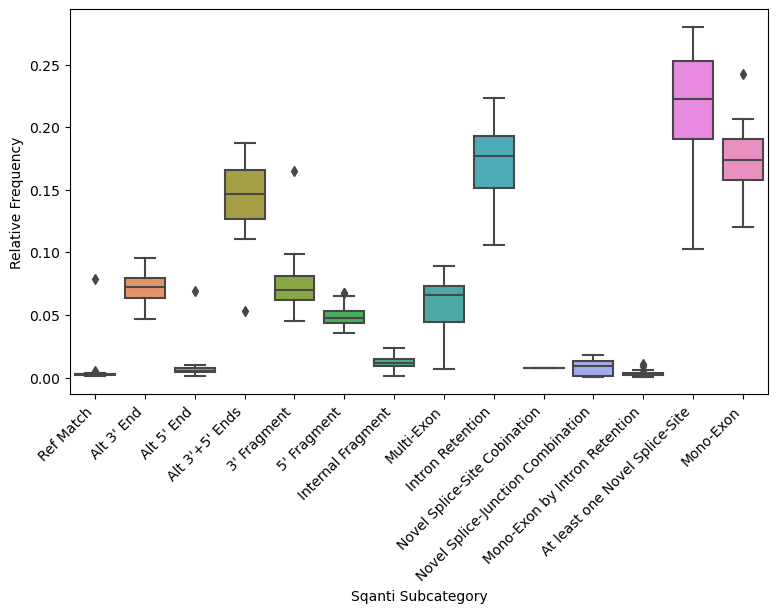

In [310]:
figure(figsize=(9, 5))
sns.set_palette(sns.color_palette("colorblind"))

ref_nlr_df=pd.DataFrame()
for acc in ref.groupby("accession"):
    df = acc[1]
    vals=df["subcategory"].value_counts().rename_axis('cat').reset_index(name='counts')
    vals["prop"]=vals["counts"].transform(lambda x: x/sum(x))
    vals["accession"]=f"{acc[0]}"
    ref_nlr_df=pd.concat([ref_nlr_df,vals])
    
    
plt_nlr=sns.boxplot(data=ref_nlr_df, x="cat", y="prop", order = order)
plt.xticks(rotation=45,horizontalalignment='right')


plt_nlr.set_xlabel("Sqanti Subcategory")
plt_nlr.set_ylabel("Relative Frequency")
plt_nlr.set_xticklabels(["Ref Match", "Alt 3' End", "Alt 5' End","Alt 3'+5' Ends","3' Fragment", "5' Fragment", "Internal Fragment", "Multi-Exon","Intron Retention",
                      "Novel Splice-Site Cobination","Novel Splice-Junction Combination","Mono-Exon by Intron Retention","At least one Novel Splice-Site","Mono-Exon"],
                     rotation=45,
                     horizontalalignment='right')
#plt_nlr.set_xticks(rotation=45, horizontalalignment='right')

In [311]:
fig = plt_nlr.get_figure()
fig.savefig("clear_cases_NLR_subcategories.png", bbox_inches='tight')

In [ ]:
rpp1=ref.loc[ref["associated_gene"]=="AT3G44480"]

In [ ]:
rpp1

In [ ]:
rpp8=ref.loc[ref["associated_gene"]=="AT5G43470"]

In [ ]:
rpp8

In [ ]:
rpp7=ref.loc[ref["associated_gene"]=="AT1G58602"]

In [ ]:
rpp7